<a href="https://colab.research.google.com/github/sertuxito/Data-Sicence-III/blob/main/TrabajoFinal_Data_Science_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# Para NLP (iremos añadiendo más según las necesitemos)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer # Lematizador y Stemmer
print("Descargando recursos de NLTK (punkt, stopwords, wordnet, omw-1.4)...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True) # Necesario para WordNetLemmatizer en algunos contextos
print("Recursos de NLTK listos.")

import spacy
# Para cargar modelos de spaCy, primero deben estar descargados.
# Si trabajas con reseñas en español, puedes usar 'es_core_news_sm' o 'es_core_news_md'.
# Si están en inglés, 'en_core_web_sm' o 'en_core_web_md'.
# Ejecuta en una celda de Colab (una sola vez):
# !python -m spacy download en_core_web_sm
# O para español:
# !python -m spacy download es_core_news_sm
# nlp_spacy_en = spacy.load('en_core_web_sm') # Ejemplo para cargar modelo en inglés
# nlp_spacy_es = spacy.load('es_core_news_sm') # Ejemplo para cargar modelo en español

from wordcloud import WordCloud

# Para Machine Learning (iremos añadiendo más)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print("Librerías fundamentales importadas.")

Descargando recursos de NLTK (punkt, stopwords, wordnet, omw-1.4)...
Recursos de NLTK listos.
Librerías fundamentales importadas.


In [8]:

# Cargar un CSV de GitHub
url='https://raw.githubusercontent.com/sertuxito/Data-Sicence-III/refs/heads/main/WomensClothingE-CommerceReviews.csv'
df=pd.read_csv(url,sep=',',header=0)
df_WClRW_original=df.copy()
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [11]:
print("\nDimensiones del dataset (df_WClRW_original):")
print(df_WClRW_original.shape)
print("\nPrimeras 5 filas del dataset (df_WClRW_original):")
print(df_WClRW_original.head())
print("\nInformación del dataset (df_WClRW_original):")
df_WClRW_original.info()
print("\nEstadísticas descriptivas básicas del dataset (df_WClRW_original):")
print(df_WClRW_original.describe(include='all'))


Dimensiones del dataset (df_WClRW_original):
(23486, 11)

Primeras 5 filas del dataset (df_WClRW_original):
   Unnamed: 0  Clothing ID  Age                    Title  \
0           0          767   33                      NaN   
1           1         1080   34                      NaN   
2           2         1077   60  Some major design flaws   
3           3         1049   50         My favorite buy!   
4           4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name 

In [15]:
df_WClRW_original.duplicated().sum()

np.int64(0)

In [16]:
df_WClRW_original.describe(include='object').T

,count,unique,top,freq
Title,19676,13993,Love it!,136
Review Text,22641,22634,Perfect fit and i've gotten so many compliment...,3
Division Name,23472,3,General,13850
Department Name,23472,6,Tops,10468
Class Name,23472,20,Dresses,6319


In [17]:
df_WClRW_original.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,23486.0,11742.500000,6779.968547,0.0,5871.25,11742.5,17613.75,23485.0
Clothing ID,23486.0,918.118709,203.298980,0.0,861.00,936.0,1078.00,1205.0
Age,23486.0,43.198544,12.279544,18.0,34.00,41.0,52.00,99.0
Rating,23486.0,4.196032,1.110031,1.0,4.00,5.0,5.00,5.0
Recommended IND,23486.0,0.822362,0.382216,0.0,1.00,1.0,1.00,1.0
Positive Feedback Count,23486.0,2.535936,5.702202,0.0,0.00,1.0,3.00,122.0


# Definición de las Variables


**Clothing ID** (Tipo: int64): Identificador único del producto de ropa de la que se emite la reseña.

**Age**(Tipo: int64): Edad del cliente que dejó la reseña.

**Title** (Tipo: object): Título de la reseña. Puede contener valores nulos.

**Review Tex**t (Tipo: object): Texto completo de la reseña. Es una variable clave para análisis de sentimiento o NLP.

**Rating** (Tipo: int64): Calificación numérica dada por el cliente (presumiblemente de 1 a 5).

**Recommended IND** (Tipo: int64): Indicador binario (0 o 1) que señala si el cliente recomienda el producto.

**Positive Feedback Count** (Tipo: int64): Número de usuarios que encontraron útil la reseña.

**Division Name** (Tipo: object): División de la tienda a la que pertenece el producto (por ejemplo, "General", "Initmates").

**Department Name**(Tipo: object): Departamento de la tienda (por ejemplo, "Dresses", "Tops").

**Class Name**Tipo: object): Clase específica del producto (por ejemplo, )."Dresses", "Blouses", "Pants"



# Objetivo General

**El propósito principal de este proyecto es aplicar técnicas de Procesamiento de Lenguaje Natural (NLP) y modelos de Aprendizaje Automático para analizar las reseñas de clientas de ropa femenina, con el objetivo de obtener información valiosa sobre su percepción del servicio, identificar los temas más relevantes y clasificar los sentimientos expresados en sus opiniones.**

Específicamente, se buscará:
1.  Realizar un análisis exploratorio de los datos de las reseñas para comprender sus características principales.
2.  Preprocesar el texto de las reseñas para prepararlo para el modelado NLP. Esto incluirá la creación de una variable `Sentiment` (Positivo/Negativo) a partir de la columna de calificación `Rating`.
3.  Aplicar técnicas de NLP para identificar patrones, temas frecuentes y nubes de palabras.
4.  Desarrollar y evaluar un modelo de aprendizaje supervisado (incluyendo Redes Neuronales segun lo aprendido) capaz de clasificar automáticamente el sentimiento de nuevas reseñas basándose en su contenido textual.
5.  Analizar los resultados del modelo con el objetivo de extraer conclusiones significativas sobre la experiencia de compra de las clientas de ropa femenina.

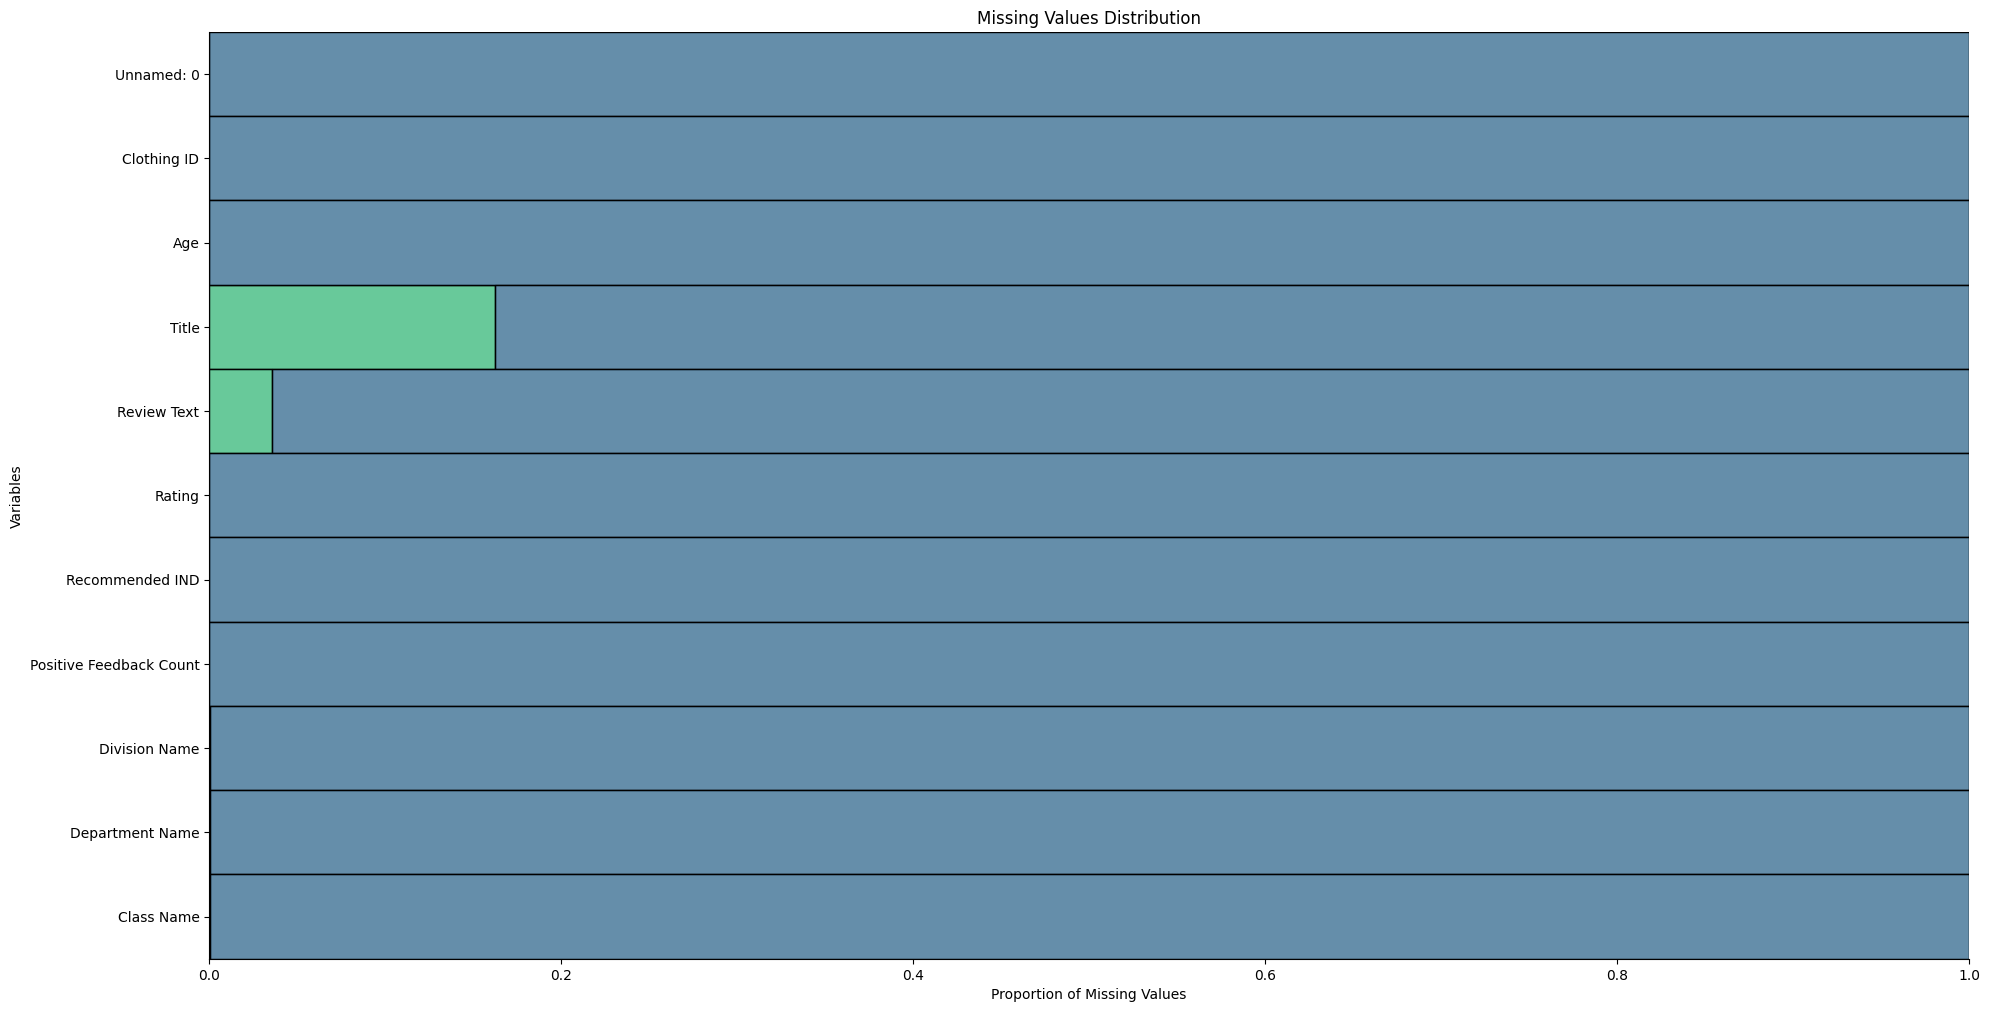

In [18]:
# Graficamos para ver la distribución de los nulos
(dfgraf:= df_WClRW_original.isnull().melt()).pipe(
    lambda df: (
        sns.displot(
            data=df,
            y='variable',
            hue='value',
            multiple='fill',
            aspect=2,         # Reducir el aspect ratio para que sea más ancho
            height=10,        # Ajustar la altura del gráfico
            palette='viridis',# Cambiar la paleta de colores
            legend=False       # Desactivar la leyenda para ahorrar espacio
        )
    )
)

# Añadir etiquetas
plt.title('Missing Values Distribution')
plt.xlabel('Proportion of Missing Values')
plt.ylabel('Variables')
plt.show()

In [19]:
df_WClRW_original.isnull().sum()

,0
Unnamed: 0,0
Clothing ID,0
Age,0
Title,3810
Review Text,845
Rating,0
Recommended IND,0
Positive Feedback Count,0
Division Name,14
Department Name,14


In [20]:
# Resumimos todo con un contador de valores nulos por cada variable
nulos_por_variable =df_WClRW_original.isnull()
cantidad_nulos_por_variable = nulos_por_variable.sum() # Sumamos los valores booleanos para obtener la cantidad de nulos por variable
variables_con_nulos = cantidad_nulos_por_variable[cantidad_nulos_por_variable > 0] # Filtramos solo las variables con al menos un valor nulo
lista_variables_con_nulos = variables_con_nulos.index.tolist() # Convertimos a lista

for variable in lista_variables_con_nulos:
    cantidad_nulos = cantidad_nulos_por_variable[variable]
    porcentaje_nulos = (cantidad_nulos / len(df_WClRW_original)) * 100
    print(f"Variable: {variable}, Cantidad de Nulos: {cantidad_nulos}, Porcentaje: {porcentaje_nulos:.2f}%")

Variable: Title, Cantidad de Nulos: 3810, Porcentaje: 16.22%
Variable: Review Text, Cantidad de Nulos: 845, Porcentaje: 3.60%
Variable: Division Name, Cantidad de Nulos: 14, Porcentaje: 0.06%
Variable: Department Name, Cantidad de Nulos: 14, Porcentaje: 0.06%
Variable: Class Name, Cantidad de Nulos: 14, Porcentaje: 0.06%


In [21]:
print("\nDimensiones del dataset (df_WClRW_original):")
print(df_WClRW_original.shape)


Dimensiones del dataset (df_WClRW_original):
(23486, 11)


In [22]:
#se eliminan aquellos que no tienen ninguna reseña ya que su porcentaje es 3,6 % no se considera un porcentaje relevante que pueda afectar el analisis de satisfaccion sobre el total de la muestra
df_WClRW_original_SN = df_WClRW_original[~df_WClRW_original['Review Text'].isnull()]

In [23]:
df_WClRW_original_SN

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [24]:
print("\nDimensiones del dataset (df_WClRW_original):")
print(df_WClRW_original_SN.shape)


Dimensiones del dataset (df_WClRW_original):
(22641, 11)


In [25]:
# Resumimos todo con un contador de valores nulos por cada variable
nulos_por_variable =df_WClRW_original_SN.isnull()
cantidad_nulos_por_variable = nulos_por_variable.sum() # Sumamos los valores booleanos para obtener la cantidad de nulos por variable
variables_con_nulos = cantidad_nulos_por_variable[cantidad_nulos_por_variable > 0] # Filtramos solo las variables con al menos un valor nulo
lista_variables_con_nulos = variables_con_nulos.index.tolist() # Convertimos a lista

for variable in lista_variables_con_nulos:
    cantidad_nulos = cantidad_nulos_por_variable[variable]
    porcentaje_nulos = (cantidad_nulos / len(df_WClRW_original)) * 100
    print(f"Variable: {variable}, Cantidad de Nulos: {cantidad_nulos}, Porcentaje: {porcentaje_nulos:.2f}%")

Variable: Title, Cantidad de Nulos: 2966, Porcentaje: 12.63%
Variable: Division Name, Cantidad de Nulos: 13, Porcentaje: 0.06%
Variable: Department Name, Cantidad de Nulos: 13, Porcentaje: 0.06%
Variable: Class Name, Cantidad de Nulos: 13, Porcentaje: 0.06%


In [28]:
# --- Verificación inicial de df_WClRW_original

print("--- Estado de df_WClRW_original (antes de crear df_processed) ---")
if 'df_WClRW_original' not in globals() and 'df_WClRW_original' not in locals():
    print("ERROR: df_WClRW_original no está definido.")
    raise NameError("df_WClRW_original no definido.")
elif df_WClRW_original.empty:
    print("ERROR: df_WClRW_original está VACÍO. Verifica la carga de datos en la celda 0.3.")
    raise ValueError("df_WClRW_original está vacío.")
else:
    # Este info() es útil para confirmar el estado inicial antes de esta sección.
    df_WClRW_original.info()

--- Estado de df_WClRW_original (antes de crear df_processed) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [38]:
# Selección y Renombrado de Columnas de Interés ---
print("\n- Selección y Renombrado de Columnas de Interés -")
columns_to_keep_and_rename = {
    'Age': 'Age',    # Edad Clienta (El nombre de la columna ya es correcto, pero la incluimos si queremos renombrar)
    'Review Text': 'Review_Text', # Texto de la reseña
    'Rating': 'Rating',        # Calificación numérica (El nombre de la columna ya es correcto)
    'Recommended IND': 'Recommended',   # 1 recomienda 0 no recomienda
}
# Creamos df_processed seleccionando y renombrando directamente.
# Usamos .get() para manejar posibles nombres de columna que no existan si la lista fuera más dinámica,
# pero dado que son nombres fijos, la selección directa también es segura una vez corregidos los nombres.
df_processed = df_WClRW_original[list(columns_to_keep_and_rename.keys())].copy()
df_processed.rename(columns=columns_to_keep_and_rename, inplace=True)
print("Columnas seleccionadas y renombradas en df_processed.")
df_processed.info() .
print(df_processed.head(3))



- Selección y Renombrado de Columnas de Interés -
Columnas seleccionadas y renombradas en df_processed.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Age          23486 non-null  int64 
 1   Review_Text  22641 non-null  object
 2   Rating       23486 non-null  int64 
 3   Recommended  23486 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 734.1+ KB
   Age                                        Review_Text  Rating  Recommended
0   33  Absolutely wonderful - silky and sexy and comf...       4            1
1   34  Love this dress!  it's sooo pretty.  i happene...       5            1
2   60  I had such high hopes for this dress and reall...       3            0



-Verificación de Filas Duplicadas (en df_processed) 
Se encontraron 683 filas duplicadas en df_processed. Eliminándolas...
Duplicados eliminados. Nuevo shape: (22803, 4)

 Análisis y Distribución de la columna 'Rating' 
Valores únicos en 'Rating': [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
Distribución de 'Rating' (Cantidad):
 Rating
1      839
2     1560
3     2861
4     4953
5    12590
Name: count, dtype: int64


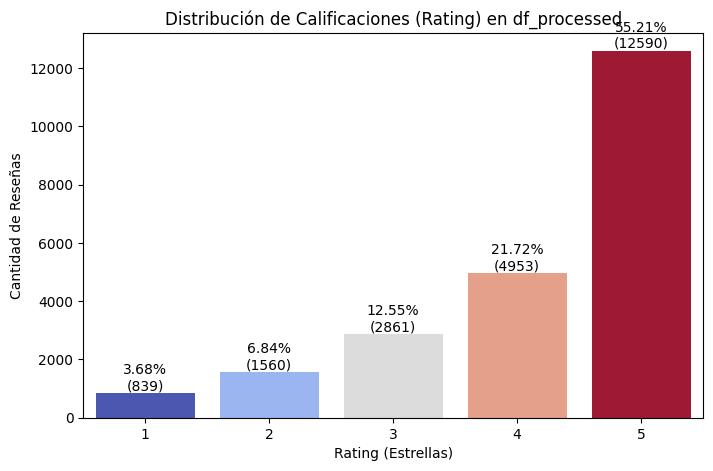

In [39]:

# Verificación de Filas Duplicadas (en df_processed) ---
print("\n-Verificación de Filas Duplicadas (en df_processed) ")
num_duplicates_processed = df_processed.duplicated().sum()
if num_duplicates_processed > 0:
    print(f"Se encontraron {num_duplicates_processed} filas duplicadas en df_processed. Eliminándolas...")
    df_processed.drop_duplicates(keep='first', inplace=True)
    print(f"Duplicados eliminados. Nuevo shape: {df_processed.shape}")
else:
    print("No se encontraron filas duplicadas en df_processed.")

#  Análisis y Distribución de la columna 'Rating' ---
print("\n Análisis y Distribución de la columna 'Rating' ")
print("Valores únicos en 'Rating':", sorted(df_processed['Rating'].unique()))
rating_counts = df_processed['Rating'].value_counts(dropna=False).sort_index()
print("Distribución de 'Rating' (Cantidad):\n", rating_counts)
plt.figure(figsize=(8, 5))
# Usar 'hue' con la misma variable que 'x' para evitar FutureWarning y mantener la funcionalidad de 'palette'
sns.countplot(data=df_processed, x='Rating', hue='Rating', order=sorted(df_processed['Rating'].unique()), palette="coolwarm", legend=False)
plt.title('Distribución de Calificaciones (Rating) en df_processed')
plt.ylabel('Cantidad de Reseñas')
plt.xlabel('Rating (Estrellas)')
ax = plt.gca()
total_rating_count = len(df_processed['Rating'])
for p in ax.patches:
    height = p.get_height()
    if total_rating_count > 0:
        percentage = 100 * height / total_rating_count
        ax.text(p.get_x() + p.get_width()/2., height + total_rating_count*0.005, f'{percentage:.2f}%\n({height:.0f})', ha="center")
plt.show()



---Creación de la Columna 'Sentiment' a partir de 'Rating' ---
Número de reseñas con Rating 3 (eliminadas): 2861
Distribución de la nueva columna 'Sentiment' (Cantidad):
 Sentiment
Positive    17543
Negative     2399
Name: count, dtype: int64
Distribución de 'Sentiment' (Porcentaje):
 Sentiment
Positive    87.970113
Negative    12.029887
Name: proportion, dtype: float64


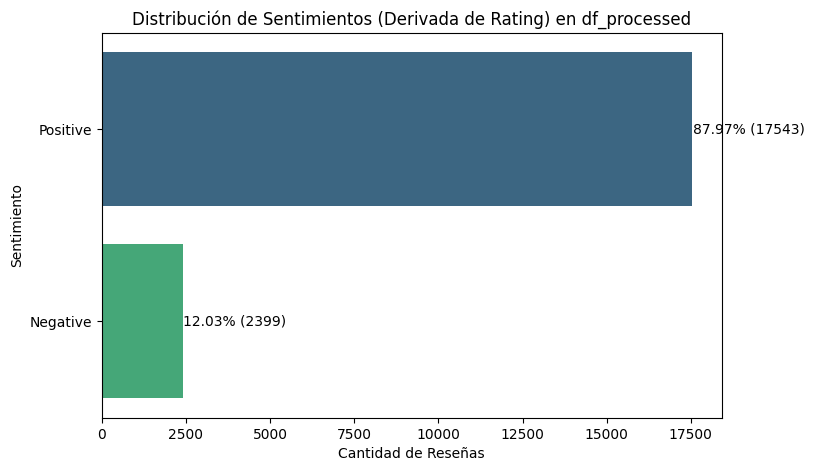

In [40]:
#Creación de la Columna 'Sentiment' a partir de 'Rating' ---
print("\n---Creación de la Columna 'Sentiment' a partir de 'Rating' ---")
initial_rows = len(df_processed)
df_processed = df_processed[df_processed['Rating'] != 3].copy()
num_rating_3_removed = initial_rows - len(df_processed)
print(f"Número de reseñas con Rating 3 (eliminadas): {num_rating_3_removed}")
conditions = [ (df_processed['Rating'] >= 4), (df_processed['Rating'] <= 2) ]
choices = [1, 0] # 1 para Positivo, 0 para Negativo
df_processed['Sentiment_Num'] = np.select(conditions, choices, default=-1) # Default -1 para chequear errores
if (df_processed['Sentiment_Num'] == -1).any():
    print("ADVERTENCIA: Algunas filas no pudieron ser mapeadas a sentimiento 0 o 1 después de quitar Rating 3.")
    # Eliminar filas que no pudieron ser mapeadas si fuera el caso (no debería ocurrir)
    # df_processed = df_processed[df_processed['Sentiment_Num'] != -1]
df_processed['Sentiment_Num'] = df_processed['Sentiment_Num'].astype(int)
df_processed['Sentiment'] = df_processed['Sentiment_Num'].map({1: 'Positive', 0: 'Negative'})
sentiment_counts = df_processed['Sentiment'].value_counts(dropna=False)
print("Distribución de la nueva columna 'Sentiment' (Cantidad):\n", sentiment_counts)
sentiment_percentage = df_processed['Sentiment'].value_counts(normalize=True, dropna=False) * 100
print("Distribución de 'Sentiment' (Porcentaje):\n", sentiment_percentage)
plt.figure(figsize=(8, 5))
# Usar 'hue' con la misma variable que 'y' para evitar FutureWarning
sns.countplot(data=df_processed, y='Sentiment', hue='Sentiment', order=sentiment_counts.index, palette="viridis", legend=False)
plt.title('Distribución de Sentimientos (Derivada de Rating) en df_processed')
plt.xlabel('Cantidad de Reseñas')
plt.ylabel('Sentimiento')
ax = plt.gca()
total_sentiment_count = len(df_processed['Sentiment'])
for i, v in enumerate(sentiment_counts):
    if total_sentiment_count > 0:
        percentage = 100 * v / total_sentiment_count
        ax.text(v + total_sentiment_count*0.001, i, f'{percentage:.2f}% ({v})', color='black', va='center')
plt.show()

In [44]:
# --- Estado final de df_processed
print("\n--- Estado final de df_processed -")
df_processed.info()
print("\nPrimeras filas de df_processed:")
print(df_processed.head())



--- Estado final de df_processed -
<class 'pandas.core.frame.DataFrame'>
Index: 19942 entries, 0 to 23485
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Age            19942 non-null  int64 
 1   Review_Text    19811 non-null  object
 2   Rating         19942 non-null  int64 
 3   Recommended    19942 non-null  int64 
 4   Sentiment_Num  19942 non-null  int64 
 5   Sentiment      19942 non-null  object
dtypes: int64(4), object(2)
memory usage: 1.1+ MB

Primeras filas de df_processed:
   Age                                        Review_Text  Rating  \
0   33  Absolutely wonderful - silky and sexy and comf...       4   
1   34  Love this dress!  it's sooo pretty.  i happene...       5   
3   50  I love, love, love this jumpsuit. it's fun, fl...       5   
4   47  This shirt is very flattering to all due to th...       5   
5   49  I love tracy reese dresses, but this one is no...       2   

   Recommended  Sen

--- Análisis de la Relación entre Rating y Sentiment (Creado) ---

Tabla de Contingencia: Rating vs. Sentiment (en df_processed)
Sentiment  Negative  Positive
Rating                       
1               839         0
2              1560         0
4                 0      4953
5                 0     12590


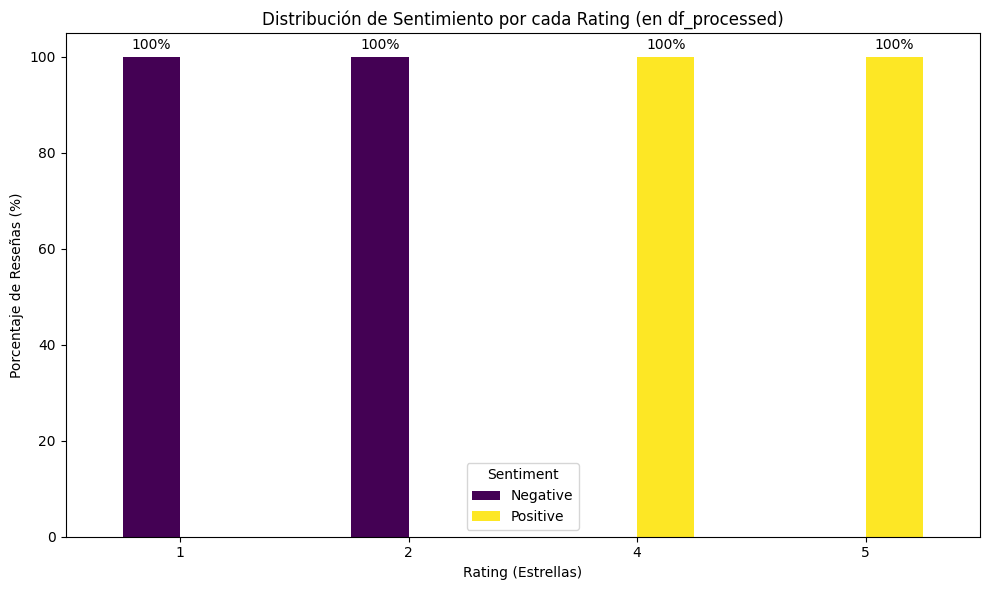


Tabla de Contingencia Normalizada por Rating (Porcentaje):
Sentiment  Negative  Positive
Rating                       
1             100.0       0.0
2             100.0       0.0
4               0.0     100.0
5               0.0     100.0


In [45]:
#  Análisis de la Relación entre Rating y Sentiment (Creado)

print("--- Análisis de la Relación entre Rating y Sentiment (Creado) ---")
# Usamos df_processed, que ya tiene 'Rating' y 'Sentiment' (creado de 'score')
# y ya no tiene los ratings de 3 estrellas.

if 'Rating' in df_processed.columns and 'Sentiment' in df_processed.columns:
    # Crear una tabla de contingencia (crosstab)
    rating_sentiment_ct = pd.crosstab(df_processed['Rating'], df_processed['Sentiment'])
    print("\nTabla de Contingencia: Rating vs. Sentiment (en df_processed)")
    print(rating_sentiment_ct)

    # Visualización de la relación (barras agrupadas)
    # Normalizar por fila (por 'Rating') para ver el porcentaje de cada sentimiento dentro de cada rating
    # Esto mostrará, por ejemplo, que todos los Rating 1 son 'Negative', todos los Rating 5 son 'Positive', etc.
    if not rating_sentiment_ct.empty: # Asegurarse de que la tabla no esté vacía
        rating_sentiment_ct_percent = rating_sentiment_ct.apply(lambda x: x / x.sum() * 100, axis=1)

        ax = rating_sentiment_ct_percent.plot(kind='bar', stacked=False, figsize=(10, 6), colormap='viridis')
        plt.title('Distribución de Sentimiento por cada Rating (en df_processed)')
        plt.ylabel('Porcentaje de Reseñas (%)')
        plt.xlabel('Rating (Estrellas)')
        plt.xticks(rotation=0)
        plt.legend(title='Sentiment')

        # Añadir etiquetas de porcentaje a las barras
        for p in ax.patches:
            width = p.get_width()
            height = p.get_height()
            if height > 0: # Solo añadir texto si la barra tiene altura (para evitar clutter)
                x, y = p.get_xy()
                ax.text(x + width/2., # Centrado en la barra
                        y + height + 1,  # Ligeramente por encima de la barra
                        f'{height:.0f}%', # Usar .0f si son 0 o 100, .1f si puede haber otros valores
                        ha='center',
                        va='bottom')
        plt.tight_layout()
        plt.show()

        print("\nTabla de Contingencia Normalizada por Rating (Porcentaje):")
        print(rating_sentiment_ct_percent.round(2))
    else:
        print("La tabla de contingencia está vacía. No se puede graficar.")

else:
    print("Error: Columnas 'Rating' o 'Sentiment' no encontradas en df_processed.")

In [46]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=b377171894d8b2974e368ba6a5794be4a0b3b8fbce46cded666f5f0e6fb274df
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


Detección del Idioma
Antes de aplicar stopwords y lematización específicas de un idioma, es una buena práctica verificar el idioma predominante de las reseñas. Esto nos ayudará a seleccionar las herramientas correctas (listas de stopwords, modelos de lematización). Si las reseñas estuvieran en múltiples idiomas de forma significativa, el enfoque necesitaría ser más complejo (ej. traducir o usar modelos multilingües). Para este proyecto, identificaremos el idioma principal (inglés, según los resultados) y procederemos con esa base, configurando spaCy y las stopwords de nltk para dicho idioma.

Preprocesamiento del Texto de las Reseñas (Review_Text)
Una vez exploradas y preparadas nuestras variables principales (incluyendo la creación de Sentiment), el siguiente paso crucial es preprocesar la columna Review_Text de nuestro DataFrame df_processed. El texto en su forma cruda no es adecuado para ser utilizado directamente por los algoritmas de Machine Learning o para análisis NLP profundos. Necesitamos limpiarlo y transformarlo en un formato más estructurado y útil.

Las tareas de preprocesamiento que realizaremos incluyen:

Identificar el idioma predominante de las reseñas para utilizar las herramientas de NLP (como listas de stopwords y modelos de lematización) adecuadas.
Conversión del texto a minúsculas.
Eliminación de signos de puntuación.
Eliminación de números (evaluaremos su relevancia, pero inicialmente los quitaremos).
Eliminación de espacios en blanco extra.
Tokenización (dividir el texto en palabras o "tokens").
Eliminación de stopwords (palabras comunes como "el", "la", "de", que no suelen aportar mucho significado al análisis de sentimiento o temas).

In [48]:
# Detección del Idioma (Usando df_processed)
# Es posible que necesites instalar langdetect:
# !pip install langdetect
from langdetect import detect, LangDetectException, DetectorFactory
import pandas as pd # Ya debería estar importado
import spacy # Ya debería estar importado
from nltk.corpus import stopwords # Ya debería estar importado
# nltk.download('stopwords') # Asegúrate de que las stopwords estén descargadas

# Asegurar resultados consistentes de langdetect si se ejecuta múltiples veces
DetectorFactory.seed = 0

print("Detección del Idioma de las Reseñas (Muestra de df_processed) ")

# Verificar que df_processed y la columna Review_Text existan y no estén vacíos
if 'df_processed' not in globals() or df_processed.empty or \
   'Review_Text' not in df_processed.columns or df_processed['Review_Text'].isnull().all():
    print("Error: df_processed no está definido, está vacío, no contiene 'Review_Text', o 'Review_Text' solo tiene nulos.")
    print("No se puede proceder con la detección de idioma.")
    # Definir nlp_spacy y nltk_stopwords como vacíos para evitar errores si no se puede proceder
    nlp_spacy = None
    nltk_stopwords = []
    # Salir de este bloque si no hay datos para procesar
    # (En un script real, podrías manejar esto de forma más elegante)
    if 'df_processed' not in globals() or df_processed.empty:
        raise NameError("df_processed no está definido o está vacío.")
    else:
        raise ValueError("Columna 'Review_Text' no disponible o vacía para la detección de idioma.")

# Crear una columna temporal para la detección, manejando nulos correctamente
# Esto evita modificar 'Review_Text' directamente si solo queremos procesar no nulos para detección
df_processed['Review_Text_Temp_Lang'] = df_processed['Review_Text'].fillna('')


# Tomar una muestra para no tardar demasiado si el dataset es muy grande.
# Ajusta sample_size si es necesario.
sample_size = min(500, len(df_processed[df_processed['Review_Text_Temp_Lang'].str.strip().astype(bool)])) # Muestra de textos no vacíos

if sample_size == 0:
    print("No hay textos no vacíos en 'Review_Text' para detectar idioma en la muestra.")
    nlp_spacy = None
    nltk_stopwords = []
else:
    # Tomar la muestra de textos que no son solo espacios en blanco
    sample_reviews = df_processed[df_processed['Review_Text_Temp_Lang'].str.strip().astype(bool)]['Review_Text_Temp_Lang'].sample(n=sample_size, random_state=42)

    languages = []
    for review_text in sample_reviews:
        try:
            # langdetect necesita al menos algunas palabras para funcionar bien.
            # Ya filtramos por str.strip().astype(bool) así que el texto no debería ser solo espacios.
            languages.append(detect(review_text))
        except LangDetectException:
            languages.append('unknown') # En caso de que no se pueda detectar (ej. texto muy corto, solo símbolos)

    detected_languages_series = pd.Series(languages)
    language_counts = detected_languages_series.value_counts(normalize=True) * 100

    print(f"\nDistribución de idiomas detectados en una muestra de {sample_size} reseñas (no vacías/solo espacios):")
    print(language_counts)

    # Determinar el idioma predominante (excluyendo 'unknown' si es posible)
    actual_language_counts = detected_languages_series[detected_languages_series != 'unknown'].value_counts(normalize=True) * 100

    predominant_language_code = None
    if not actual_language_counts.empty:
        predominant_language_code = actual_language_counts.index[0]
        predominant_language_percentage = actual_language_counts.iloc[0]
        print(f"\nEl idioma predominante (real, excluyendo 'unknown') detectado es: '{predominant_language_code}' (con un {predominant_language_percentage:.2f}% en la muestra).")
    else:
        print("\nNo se pudo determinar un idioma predominante 'real' a partir de la muestra (podría ser que todos los textos fueran 'unknown').")

    # Configurar herramientas de NLP basadas en el idioma predominante
    nlp_spacy = None # Modelo de Spacy (para lematización)
    nltk_stopwords = [] # Lista de stopwords de NLTK

    if predominant_language_code == 'en':
        print("\nConfigurando para INGLÉS.")
        try:
            nlp_spacy = spacy.load('en_core_web_sm') # Modelo pequeño para eficiencia
            print("Modelo spaCy 'en_core_web_sm' cargado para lematización en inglés.")
            nltk_stopwords = stopwords.words('english')
            print(f"Se usarán {len(nltk_stopwords)} stopwords en inglés de NLTK.")
        except OSError:
            print("Error al cargar 'en_core_web_sm'. Por favor, descárgalo ejecutando en una nueva celda:")
            print("!python -m spacy download en_core_web_sm")
        except LookupError:
            print("Error al cargar stopwords en inglés. Asegúrate de haber ejecutado nltk.download('stopwords')")

    elif predominant_language_code == 'es':
        print("\nConfigurando para ESPAÑOL.")
        try:
            nlp_spacy = spacy.load('es_core_news_sm') # Modelo pequeño para eficiencia
            print("Modelo spaCy 'es_core_news_sm' cargado para lematización en español.")
            nltk_stopwords = stopwords.words('spanish')
            print(f"Se usarán {len(nltk_stopwords)} stopwords en español de NLTK.")
        except OSError:
            print("Error al cargar 'es_core_news_sm'. Por favor, descárgalo ejecutando en una nueva celda:")
            print("!python -m spacy download es_core_news_sm")
        except LookupError:
            print("Error al cargar stopwords en español. Asegúrate de haber ejecutado nltk.download('stopwords')")
    else:
        print(f"\nIdioma predominante '{predominant_language_code}' no es 'en' ni 'es', o no se pudo determinar con certeza.")
        print("Se procederá SIN lematización específica de spaCy y SIN stopwords predefinidas de NLTK.")
        print("Para estas funcionalidades, considera añadir soporte para este idioma o usar herramientas multilingües.")

# Limpiar la columna temporal usada para la detección de idioma
if 'Review_Text_Temp_Lang' in df_processed.columns:
    df_processed.drop(columns=['Review_Text_Temp_Lang'], inplace=True)

# Verificaciones finales de las herramientas de NLP
if nlp_spacy is None:
    print("\nADVERTENCIA: El modelo de spaCy (nlp_spacy) NO está cargado. La lematización no funcionará como se espera.")
if not nltk_stopwords: # Si la lista está vacía
    print("\nADVERTENCIA: La lista de stopwords (nltk_stopwords) está VACÍA. No se eliminarán stopwords automáticamente.")

Detección del Idioma de las Reseñas (Muestra de df_processed) 

Distribución de idiomas detectados en una muestra de 500 reseñas (no vacías/solo espacios):
en    99.8
da     0.2
Name: proportion, dtype: float64

El idioma predominante (real, excluyendo 'unknown') detectado es: 'en' (con un 99.80% en la muestra).

Configurando para INGLÉS.
Modelo spaCy 'en_core_web_sm' cargado para lematización en inglés.
Se usarán 198 stopwords en inglés de NLTK.


In [49]:
# 1.2.1. Limpieza de Texto Inicial (Minúsculas, Puntuación, Números, Espacios)
import re
import string # Para obtener string.punctuation

print("--- 1.2.1. Aplicando Limpieza de Texto Inicial a 'Review_Text' ---")

# Verificar que df_processed y Review_Text existan
if 'df_processed' not in globals() or 'Review_Text' not in df_processed.columns:
    print("Error: df_processed o la columna 'Review_Text' no están definidos. Verifica los pasos anteriores.")
    raise NameError("df_processed o Review_Text no definidos para limpieza.")

# 1. Crear la columna 'Review_Text_Clean' y manejar nulos convirtiéndolos a cadena vacía
# Esto asegura que todas las operaciones de string funcionarán.
df_processed['Review_Text_Clean'] = df_processed['Review_Text'].fillna('').astype(str)
print("Paso 0: Columna 'Review_Text_Clean' creada y nulos manejados (convertidos a '').")

# 2. Convertir a minúsculas
df_processed['Review_Text_Clean'] = df_processed['Review_Text_Clean'].str.lower()
print("Paso 1: Texto convertido a minúsculas.")

# 3. Eliminar signos de puntuación
# string.punctuation contiene !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
# Creamos una tabla de traducción que mapea cada signo de puntuación a None (para eliminarlo)
translator = str.maketrans('', '', string.punctuation)
df_processed['Review_Text_Clean'] = df_processed['Review_Text_Clean'].apply(lambda text: text.translate(translator))
print("Paso 2: Signos de puntuación eliminados.")

# 4. Eliminar números
# Usamos expresiones regulares: \d+ coincide con uno o más dígitos
df_processed['Review_Text_Clean'] = df_processed['Review_Text_Clean'].apply(lambda text: re.sub(r'\d+', '', text))
print("Paso 3: Números eliminados.")

# 5. Eliminar espacios en blanco extra (al principio, al final y múltiples espacios intermedios)
# Primero .strip() para los extremos, luego reemplazar múltiples espacios con uno solo.
df_processed['Review_Text_Clean'] = df_processed['Review_Text_Clean'].apply(lambda text: " ".join(text.strip().split()))
print("Paso 4: Espacios en blanco extra eliminados.")

# Mostrar algunas filas con el texto original y el texto limpiado para comparar
print("\nComparación de Review_Text original y Review_Text_Clean (primeras 5 filas):")
if not df_processed.empty:
    # Seleccionar solo algunas filas para no imprimir demasiado si el df es grande
    sample_display = df_processed[['Review_Text', 'Review_Text_Clean']].head()
    # Para mejor visualización en la salida si los textos son largos:
    for index, row in sample_display.iterrows():
        print(f"\n--- Fila {index} ---")
        print(f"Original: {row['Review_Text']}")
        print(f"Limpiado: {row['Review_Text_Clean']}")
else:
    print("DataFrame df_processed está vacío.")

# Verificar si después de la limpieza algunos textos quedaron completamente vacíos
empty_after_cleaning = df_processed[df_processed['Review_Text_Clean'] == ''].shape[0]
if empty_after_cleaning > 0:
    print(f"\nAdvertencia: {empty_after_cleaning} reseñas quedaron como una cadena vacía después de la limpieza inicial.")
    # Considerar si estas filas deben ser eliminadas o cómo manejarlas.
    # Por ejemplo, si una reseña era solo "123 !!!", ahora estará vacía.

print("\n--- df_processed después de la limpieza inicial de texto ---")
df_processed.info() # Para ver la nueva columna y su estado
print(df_processed[['Sentiment', 'Review_Text', 'Review_Text_Clean']].head())

--- 1.2.1. Aplicando Limpieza de Texto Inicial a 'Review_Text' ---
Paso 0: Columna 'Review_Text_Clean' creada y nulos manejados (convertidos a '').
Paso 1: Texto convertido a minúsculas.
Paso 2: Signos de puntuación eliminados.
Paso 3: Números eliminados.
Paso 4: Espacios en blanco extra eliminados.

Comparación de Review_Text original y Review_Text_Clean (primeras 5 filas):

--- Fila 0 ---
Original: Absolutely wonderful - silky and sexy and comfortable
Limpiado: absolutely wonderful silky and sexy and comfortable

--- Fila 1 ---
Original: Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.
Limpiado: love this dress its sooo pretty i happened to find it in a store and im glad i did bc i never would have ordered it online bc its petite i b

# Tokenizacion

In [50]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [51]:
#Tokenización
from nltk.tokenize import word_tokenize
# nltk.download('punkt') # Asegúrate de que el tokenizador 'punkt' de NLTK esté descargado

print("--- 1.2.2. Aplicando Tokenización a 'Review_Text_Clean' ---")

# Verificar que df_processed y Review_Text_Clean existan
if 'df_processed' not in globals() or 'Review_Text_Clean' not in df_processed.columns:
    print("Error: df_processed o la columna 'Review_Text_Clean' no están definidos. Verifica los pasos anteriores.")
    raise NameError("df_processed o Review_Text_Clean no definidos para tokenización.")

# Aplicar tokenización a cada reseña en la columna 'Review_Text_Clean'
# El resultado será una nueva columna (ej. 'Tokens') que contiene listas de palabras.
# Asegurarnos de que nltk.download('punkt') se haya ejecutado al menos una vez en el entorno.
try:
    df_processed['Tokens'] = df_processed['Review_Text_Clean'].apply(word_tokenize)
    print("Tokenización completada.")
except LookupError as e:
    print(f"Error de NLTK: {e}. Es posible que necesites descargar el recurso 'punkt'.")
    print("Ejecuta en una celda nueva: import nltk; nltk.download('punkt')")
    # No continuar si la tokenización falla
    raise
except Exception as e:
    print(f"Un error inesperado ocurrió durante la tokenización: {e}")
    raise


# Mostrar las primeras filas con la nueva columna 'Tokens'
print("\nPrimeras 5 filas de df_processed con la columna 'Tokens':")
if not df_processed.empty:
    # Muestra las columnas relevantes para ver el resultado de la tokenización
    print(df_processed[['Review_Text_Clean', 'Tokens']].head())
else:
    print("DataFrame df_processed está vacío.")

# Información actualizada del DataFrame
print("\n--- df_processed después de la tokenización ---")
df_processed.info()

--- 1.2.2. Aplicando Tokenización a 'Review_Text_Clean' ---
Tokenización completada.

Primeras 5 filas de df_processed con la columna 'Tokens':
                                   Review_Text_Clean  \
0  absolutely wonderful silky and sexy and comfor...   
1  love this dress its sooo pretty i happened to ...   
3  i love love love this jumpsuit its fun flirty ...   
4  this shirt is very flattering to all due to th...   
5  i love tracy reese dresses but this one is not...   

                                              Tokens  
0  [absolutely, wonderful, silky, and, sexy, and,...  
1  [love, this, dress, its, sooo, pretty, i, happ...  
3  [i, love, love, love, this, jumpsuit, its, fun...  
4  [this, shirt, is, very, flattering, to, all, d...  
5  [i, love, tracy, reese, dresses, but, this, on...  

--- df_processed después de la tokenización ---
<class 'pandas.core.frame.DataFrame'>
Index: 19942 entries, 0 to 23485
Data columns (total 8 columns):
 #   Column             Non-Null Coun

# Eliminación de Stopwords

In [52]:
# Eliminación de Stopwords

print("--- 1.2.3. Aplicando Eliminación de Stopwords a la columna 'Tokens' ---")

# Verificar que df_processed, la columna 'Tokens', y la lista nltk_stopwords existan
if 'df_processed' not in globals() or 'Tokens' not in df_processed.columns:
    print("Error: df_processed o la columna 'Tokens' no están definidos. Verifica los pasos anteriores.")
    raise NameError("df_processed o Tokens no definidos para eliminación de stopwords.")

if 'nltk_stopwords' not in globals() or not isinstance(nltk_stopwords, list):
    print("Error: La lista 'nltk_stopwords' no está definida o no es una lista.")
    print("Asegúrate de que la sección de detección de idioma (1.2.0) se haya ejecutado correctamente y configurado nltk_stopwords.")
    # Si nltk_stopwords no se configuró (ej. idioma no soportado y no configurado manualmente),
    # podemos optar por no hacer nada o usar una lista vacía para que el código no falle.
    # Aquí, es mejor detenerse si no está configurada como se esperaba.
    raise ValueError("nltk_stopwords no configurada correctamente.")

if not nltk_stopwords: # Si la lista está vacía (ej. idioma no soportado y no configurado manualmente)
    print("Advertencia: La lista de stopwords (nltk_stopwords) está vacía.")
    print("No se eliminarán stopwords. Si esto no es lo esperado, revisa la configuración de idioma en 1.2.0.")
    # Si la lista está vacía, aplicar la función no cambiará nada, así que podemos simplemente copiar los tokens.
    df_processed['Tokens_NoStopwords'] = df_processed['Tokens']
else:
    print(f"Utilizando {len(nltk_stopwords)} stopwords para el idioma configurado (ej. inglés: {nltk_stopwords[:5]}...).")
    # Convertir la lista de stopwords a un conjunto (set) para una búsqueda más eficiente
    stopwords_set = set(nltk_stopwords)

    # Función para eliminar stopwords de una lista de tokens
    def remove_stopwords(tokens_list):
        return [word for word in tokens_list if word.lower() not in stopwords_set] # .lower() por si acaso algún token no estuviera en minúscula

    # Aplicar la función a la columna 'Tokens'
    df_processed['Tokens_NoStopwords'] = df_processed['Tokens'].apply(remove_stopwords)
    print("Eliminación de stopwords completada.")

# Mostrar las primeras filas con la nueva columna 'Tokens_NoStopwords'
print("\nPrimeras 5 filas de df_processed con la columna 'Tokens_NoStopwords':")
if not df_processed.empty:
    # Muestra las columnas relevantes para ver el resultado
    print(df_processed[['Tokens', 'Tokens_NoStopwords']].head())
else:
    print("DataFrame df_processed está vacío.")

# Comparar la longitud de los tokens antes y después de eliminar stopwords para algunas reseñas
if not df_processed.empty and 'Tokens_NoStopwords' in df_processed.columns:
    print("\nComparación de longitud de tokens (ejemplos):")
    for i in range(min(5, len(df_processed))): # Mostrar para las primeras 5 filas
        original_len = len(df_processed['Tokens'].iloc[i])
        nostop_len = len(df_processed['Tokens_NoStopwords'].iloc[i])
        if original_len > nostop_len: # Solo imprimir si hubo cambio
            print(f"Fila {df_processed.index[i]}: Longitud original = {original_len}, Longitud sin stopwords = {nostop_len}")
            print(f"  Original: {df_processed['Tokens'].iloc[i]}")
            print(f"  Sin Stop: {df_processed['Tokens_NoStopwords'].iloc[i]}")


# Información actualizada del DataFrame
print("\n--- df_processed después de la eliminación de stopwords ---")
df_processed.info()

--- 1.2.3. Aplicando Eliminación de Stopwords a la columna 'Tokens' ---
Utilizando 198 stopwords para el idioma configurado (ej. inglés: ['a', 'about', 'above', 'after', 'again']...).
Eliminación de stopwords completada.

Primeras 5 filas de df_processed con la columna 'Tokens_NoStopwords':
                                              Tokens  \
0  [absolutely, wonderful, silky, and, sexy, and,...   
1  [love, this, dress, its, sooo, pretty, i, happ...   
3  [i, love, love, love, this, jumpsuit, its, fun...   
4  [this, shirt, is, very, flattering, to, all, d...   
5  [i, love, tracy, reese, dresses, but, this, on...   

                                  Tokens_NoStopwords  
0  [absolutely, wonderful, silky, sexy, comfortable]  
1  [love, dress, sooo, pretty, happened, find, st...  
3  [love, love, love, jumpsuit, fun, flirty, fabu...  
4  [shirt, flattering, due, adjustable, front, ti...  
5  [love, tracy, reese, dresses, one, petite, fee...  

Comparación de longitud de tokens (ejemp

# Lematización

In [53]:
# Lematización

print("---  Aplicando Lematización a 'Tokens_NoStopwords' ---")

# Verificar que df_processed, 'Tokens_NoStopwords', y el modelo nlp_spacy existan
if 'df_processed' not in globals() or 'Tokens_NoStopwords' not in df_processed.columns:
    print("Error: df_processed o la columna 'Tokens_NoStopwords' no están definidos. Verifica los pasos anteriores.")
    raise NameError("df_processed o Tokens_NoStopwords no definidos para lematización.")

if 'nlp_spacy' not in globals() or nlp_spacy is None:
    print("Error: El modelo de spaCy (nlp_spacy) no está cargado o no está definido.")
    print("Asegúrate de que la sección de detección de idioma (1.2.0) se haya ejecutado correctamente y configurado nlp_spacy.")
    print("Si el modelo no se cargó, la lematización no se realizará. Procediendo sin lematizar o deteniendo (elegir).")
    raise ValueError("Modelo nlp_spacy no disponible para lematización.")

# Función para lematizar una lista de tokens usando spaCy
# spaCy procesa una cadena, no una lista de tokens directamente para .lemma_
# Así que unimos los tokens y luego reprocesamos, o lematizamos token por token.
# Lematizar token por token es más directo si ya tenemos tokens.
def lemmatize_tokens(tokens_list):
    # Convertir la lista de tokens en un documento spaCy uniendo los tokens y luego procesando.
    # Esto permite a spaCy aplicar su pipeline completo (POS tagging, etc.) que mejora la lematización.
    # Sin embargo, si los tokens ya están muy limpios, podríamos procesar palabra por palabra,
    # pero unir y reprocesar suele ser más robusto para la calidad de la lematización.
    if not tokens_list: # Si la lista de tokens está vacía
        return []

    # Unir los tokens para crear una cadena, luego procesar con spaCy
    text_to_process = " ".join(tokens_list)
    doc = nlp_spacy(text_to_process)

    # Extraer el lema de cada token en el documento procesado
    # Solo consideramos tokens que no sean de puntuación ni espacios (aunque la mayoría ya deberían estar limpios)
    lemmatized_list = [token.lemma_.lower().strip() for token in doc if not token.is_punct and not token.is_space]

    # Asegurarse de que no queden tokens vacíos después de .strip()
    return [lemma for lemma in lemmatized_list if lemma]


print(f"Aplicando lematización con el modelo spaCy: {nlp_spacy.meta['name']} ({nlp_spacy.meta['lang']})")

# Aplicar la función a la columna 'Tokens_NoStopwords'
# Esto puede tardar un poco dependiendo del tamaño del DataFrame y la complejidad de los textos.
df_processed['Tokens_Lematizados'] = df_processed['Tokens_NoStopwords'].apply(lemmatize_tokens)
print("Lematización completada.")

# Mostrar las primeras filas con la nueva columna 'Tokens_Lematizados'
print("\nPrimeras 5 filas de df_processed con la columna 'Tokens_Lematizados':")
if not df_processed.empty:
    # Muestra las columnas relevantes para ver el resultado
    # Aumentar el ancho de la columna para visualización si es necesario
    with pd.option_context('display.max_colwidth', 100): # Muestra más contenido de las celdas
        print(df_processed[['Tokens_NoStopwords', 'Tokens_Lematizados']].head())
else:
    print("DataFrame df_processed está vacío.")

# Comparar algunos ejemplos
if not df_processed.empty and 'Tokens_Lematizados' in df_processed.columns:
    print("\nComparación de tokens sin stopwords vs. lematizados (ejemplos):")
    # Filtrar algunas filas que podrían mostrar cambios interesantes (ej. verbos conjugados, plurales)
    # Esto es solo para demostración, puedes elegir otros índices o formas de muestrear.
    indices_ejemplo = df_processed[df_processed['Tokens_NoStopwords'].apply(len) > 2].head(5).index
    if len(indices_ejemplo) < 5 : # Si no hay suficientes, tomar las primeras 5
        indices_ejemplo = df_processed.head(5).index

    for i in indices_ejemplo:
        # Verificar si el índice todavía existe en el df_processed (por si se eliminaron filas)
        if i in df_processed.index:
            print(f"\n--- Fila {i} ---")
            print(f"  Sin Stopwords : {df_processed.loc[i, 'Tokens_NoStopwords']}")
            print(f"  Lematizados   : {df_processed.loc[i, 'Tokens_Lematizados']}")


# Información actualizada del DataFrame
print("\n--- df_processed después de la lematización ---")
df_processed.info()

--- 1.2.4. Aplicando Lematización a 'Tokens_NoStopwords' ---
Aplicando lematización con el modelo spaCy: core_web_sm (en)
Lematización completada.

Primeras 5 filas de df_processed con la columna 'Tokens_Lematizados':
                                                                                    Tokens_NoStopwords  \
0                                                    [absolutely, wonderful, silky, sexy, comfortable]   
1  [love, dress, sooo, pretty, happened, find, store, im, glad, bc, never, would, ordered, online, ...   
3  [love, love, love, jumpsuit, fun, flirty, fabulous, every, time, wear, get, nothing, great, comp...   
4  [shirt, flattering, due, adjustable, front, tie, perfect, length, wear, leggings, sleeveless, pa...   
5  [love, tracy, reese, dresses, one, petite, feet, tall, usually, wear, p, brand, dress, pretty, p...   

                                                                                    Tokens_Lematizados  
0                                       

#Creación de Nube de Palabras (Word Cloud)

--- Creando Nubes de Palabras ---

Generando Nube de Palabras General...


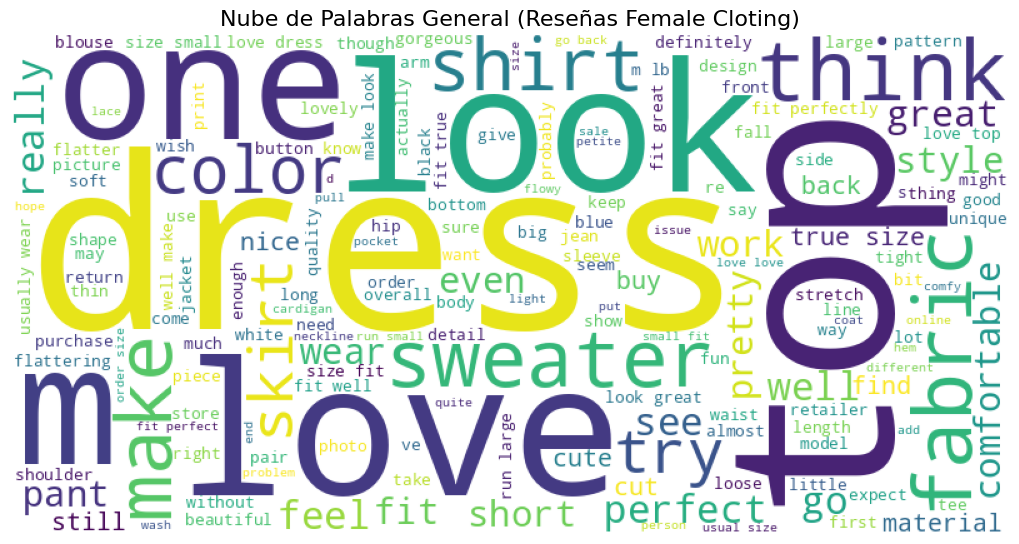


Generando Nube de Palabras para Reseñas Positivas...


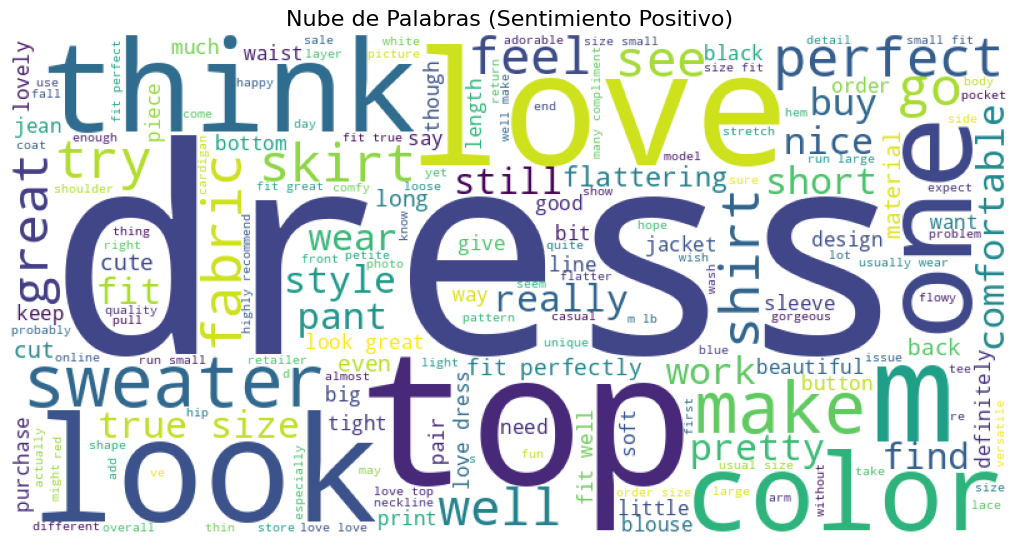


Generando Nube de Palabras para Reseñas Negativas...


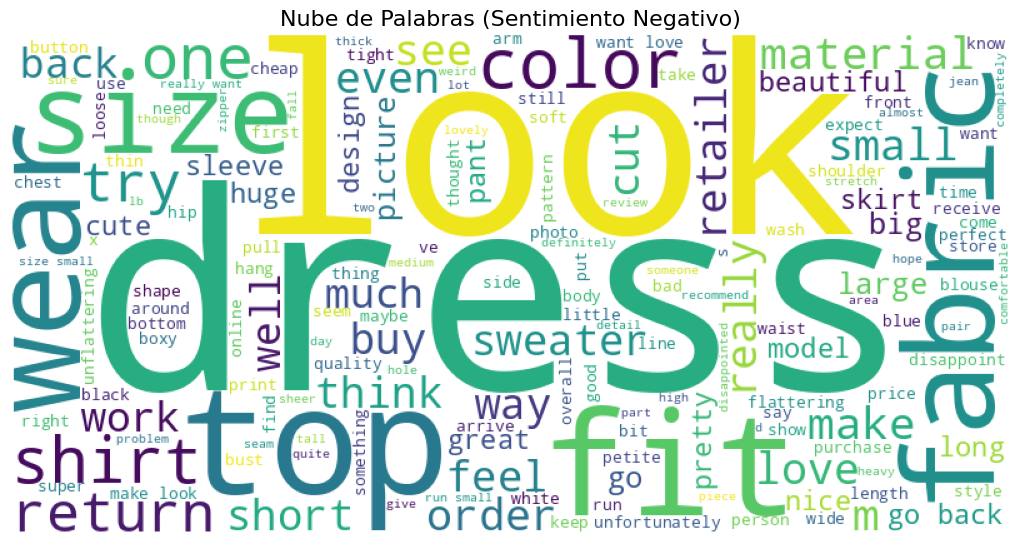

In [55]:
#Creación de Nube de Palabras (Word Cloud)
from wordcloud import WordCloud # Ya debería estar importada
import matplotlib.pyplot as plt # Ya debería estar importada

print("--- Creando Nubes de Palabras ---")

# Verificar que df_processed y 'Tokens_Lematizados' existan
if 'df_processed' not in globals() or 'Tokens_Lematizados' not in df_processed.columns:
    print("Error: df_processed o la columna 'Tokens_Lematizados' no están definidos.")
    raise NameError("df_processed o Tokens_Lematizados no definidos para nubes de palabras.")
if df_processed['Tokens_Lematizados'].empty:
    print("La columna 'Tokens_Lematizados' está vacía. No se pueden generar nubes de palabras.")
    # Salir si no hay datos
    # (En un script real, esto podría manejarse de otra forma)
else:
    # Función para generar y mostrar una nube de palabras
    def generar_nube_palabras(text_series, title):
        # Unir todas las listas de tokens en una sola gran cadena de texto
        # Asegurarse de que cada "palabra" (token) esté separada por un espacio
        text_corpus = " ".join([" ".join(tokens) for tokens in text_series if tokens]) # Manejar listas vacías de tokens

        if not text_corpus.strip(): # Si el corpus está vacío o solo espacios
            print(f"No hay suficientes palabras para generar la nube de '{title}'. El corpus de texto está vacío.")
            return

        wordcloud = WordCloud(width=800, height=400,
                              background_color='white',
                              stopwords=None, # Ya hemos quitado stopwords, pero WordCloud tiene su propia lista que podemos desactivar
                              min_font_size=10).generate(text_corpus)

        plt.figure(figsize=(10, 5), facecolor=None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad=0)
        plt.title(title, fontsize=16)
        plt.show()

    # 1. Nube de palabras para todas las reseñas
    print("\nGenerando Nube de Palabras General...")
    generar_nube_palabras(df_processed['Tokens_Lematizados'], 'Nube de Palabras General (Reseñas Female Cloting)')

    # 2. Nube de palabras para reseñas POSITIVAS
    print("\nGenerando Nube de Palabras para Reseñas Positivas...")
    df_positivas = df_processed[df_processed['Sentiment'] == 'Positive']
    if not df_positivas.empty:
        generar_nube_palabras(df_positivas['Tokens_Lematizados'], 'Nube de Palabras (Sentimiento Positivo)')
    else:
        print("No hay reseñas positivas para generar la nube de palabras.")

    # 3. Nube de palabras para reseñas NEGATIVAS
    print("\nGenerando Nube de Palabras para Reseñas Negativas...")
    df_negativas = df_processed[df_processed['Sentiment'] == 'Negative']
    if not df_negativas.empty:
        generar_nube_palabras(df_negativas['Tokens_Lematizados'], 'Nube de Palabras (Sentimiento Negativo)')
    else:
        print("No hay reseñas negativas para generar la nube de palabras.")

# #Análisis de N-gramas

--- Realizando Análisis de N-gramas ---

--- Bigramas Más Comunes (General) ---
          N_grama  Frecuencia
0             i m        5216
1          do not        3756
2       true size        1210
3          be not        1181
4   fit perfectly        1023
5      look great         929
6       look like         918
7         can not         850
8            i ve         847
9      love dress         757
10       fit well         706
11   usually wear         618
12      feel like         601
13     size small         597
14       love top         585

--- Bigramas Más Comunes (Sentimiento Positivo) ---
         N_grama  Frecuencia
0            i m        4725
1         do not        3169
2      true size        1161
3  fit perfectly         993
4         be not         982
5     look great         883
6           i ve         765
7        can not         750
8     love dress         697
9       fit well         648

--- Bigramas Más Comunes (Sentimiento Negativo) ---
     N_grama  F

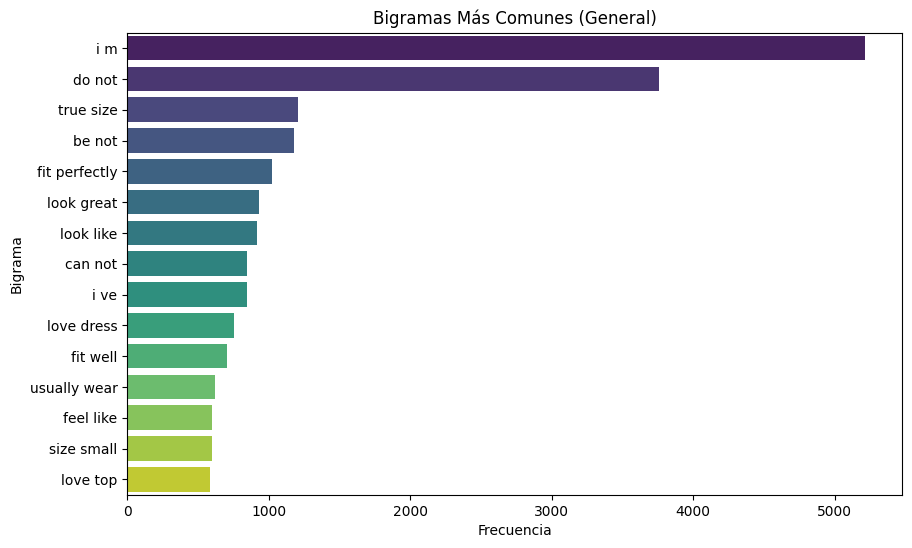

In [56]:
 #Análisis de N-gramas
from nltk.util import ngrams
from collections import Counter
import pandas as pd # Asegurar que pandas esté disponible

print("--- Realizando Análisis de N-gramas ---")

# Verificar que df_processed y 'Tokens_Lematizados' existan
if 'df_processed' not in globals() or 'Tokens_Lematizados' not in df_processed.columns:
    print("Error: df_processed o la columna 'Tokens_Lematizados' no están definidos.")
    raise NameError("df_processed o Tokens_Lematizados no definidos para análisis de N-gramas.")
if df_processed['Tokens_Lematizados'].empty:
    print("La columna 'Tokens_Lematizados' está vacía. No se puede realizar el análisis de N-gramas.")
else:
    # Función para generar y contar n-gramas de una serie de listas de tokens
    def obtener_n_gramas_comunes(series_tokens_lematizados, n_gram_valor, top_n=15):
        # Primero, aplanar la lista de listas de tokens en una sola lista de tokens
        todos_los_tokens = [token for sublist in series_tokens_lematizados if sublist for token in sublist] # Manejar listas vacías

        if not todos_los_tokens or len(todos_los_tokens) < n_gram_valor:
            print(f"No hay suficientes tokens para generar {n_gram_valor}-gramas.")
            return pd.DataFrame() # Devolver DataFrame vacío

        # Generar n-gramas
        n_gram_lista = list(ngrams(todos_los_tokens, n_gram_valor))

        if not n_gram_lista:
            print(f"No se generaron {n_gram_valor}-gramas (la lista está vacía después de ngrams).")
            return pd.DataFrame()

        # Contar la frecuencia de cada n-grama
        n_gram_counts = Counter(n_gram_lista)

        # Convertir a DataFrame para mejor visualización
        df_n_gramas = pd.DataFrame(n_gram_counts.most_common(top_n), columns=['N_grama', 'Frecuencia'])
        # Unir los tokens del N-grama en una cadena para mejor lectura
        df_n_gramas['N_grama'] = df_n_gramas['N_grama'].apply(lambda x: ' '.join(x))

        return df_n_gramas

    # --- Bigramas (2-gramas) ---
    print("\n--- Bigramas Más Comunes (General) ---")
    df_bigramas_general = obtener_n_gramas_comunes(df_processed['Tokens_Lematizados'], 2, top_n=15)
    if not df_bigramas_general.empty:
        print(df_bigramas_general)
    else:
        print("No se pudieron generar bigramas generales.")

    print("\n--- Bigramas Más Comunes (Sentimiento Positivo) ---")
    df_positivas_tokens = df_processed[df_processed['Sentiment'] == 'Positive']['Tokens_Lematizados']
    if not df_positivas_tokens.empty:
        df_bigramas_positivos = obtener_n_gramas_comunes(df_positivas_tokens, 2, top_n=10)
        if not df_bigramas_positivos.empty:
            print(df_bigramas_positivos)
        else:
            print("No se pudieron generar bigramas para reseñas positivas.")
    else:
        print("No hay reseñas positivas para analizar bigramas.")

    print("\n--- Bigramas Más Comunes (Sentimiento Negativo) ---")
    df_negativas_tokens = df_processed[df_processed['Sentiment'] == 'Negative']['Tokens_Lematizados']
    if not df_negativas_tokens.empty:
        df_bigramas_negativos = obtener_n_gramas_comunes(df_negativas_tokens, 2, top_n=10)
        if not df_bigramas_negativos.empty:
            print(df_bigramas_negativos)
        else:
            print("No se pudieron generar bigramas para reseñas negativas.")
    else:
        print("No hay reseñas negativas para analizar bigramas.")

    # --- Trigramas (3-gramas) ---
    # Suelen ser menos frecuentes, así que podríamos buscar un top_n más pequeño o esperar menos resultados.
    print("\n--- Trigramas Más Comunes (General) ---")
    df_trigramas_general = obtener_n_gramas_comunes(df_processed['Tokens_Lematizados'], 3, top_n=15)
    if not df_trigramas_general.empty:
        print(df_trigramas_general)
    else:
        print("No se pudieron generar trigramas generales.")

    print("\n--- Trigramas Más Comunes (Sentimiento Positivo) ---")
    if not df_positivas_tokens.empty:
        df_trigramas_positivos = obtener_n_gramas_comunes(df_positivas_tokens, 3, top_n=10)
        if not df_trigramas_positivos.empty:
            print(df_trigramas_positivos)
        else:
            print("No se pudieron generar trigramas para reseñas positivas.")
    else:
        print("No hay reseñas positivas para analizar trigramas.")

    print("\n--- Trigramas Más Comunes (Sentimiento Negativo) ---")
    if not df_negativas_tokens.empty:
        df_trigramas_negativos = obtener_n_gramas_comunes(df_negativas_tokens, 3, top_n=10)
        if not df_trigramas_negativos.empty:
            print(df_trigramas_negativos)
        else:
            print("No se pudieron generar trigramas para reseñas negativas.")
    else:
        print("No hay reseñas negativas para analizar trigramas.")

# Por ejemplo, para df_bigramas_general:
if not df_bigramas_general.empty:
     plt.figure(figsize=(10, 6))
     sns.barplot(data=df_bigramas_general, x='Frecuencia', y='N_grama', hue='N_grama', palette='viridis', legend=False)
     plt.title('Bigramas Más Comunes (General)')
     plt.xlabel('Frecuencia')
     plt.ylabel('Bigrama')
     plt.show()

**Bigramas Positivos**

Frases como "fit perfectly", "look great", y "love dress" reflejan satisfacción con el producto.


**Bigramas Negativos**

Frases como "do not", "look like", y "go back" indican decepción o insatisfacción.




**Trigramas Generales**

Frases como **"fit true size"** y **"can not wait"** son comunes, reflejando tanto expectativas como experiencias.

Trigramas Positivos

"**receive many compliment**", "**i m glad"**, y "**not wait wear**" muestran entusiasmo y aprobación.

Trigramas Negativos

"**do not work**", "**make look like**", y **"do not fit**" son señales claras de problemas con el producto o la experiencia.


**Interpretación General**
Los n-gramas positivos tienden a centrarse en ajuste, apariencia y emoción positiva.
Los n-gramas negativos destacan problemas funcionales o de expectativa, como que algo "no funciona", "no encaja" o "no se ve bien".
Este análisis puede ayudarte a:
Mejorar descripciones de productos.
Detectar patrones de insatisfacción.
Entrenar modelos de clasificación más precisos usando estos n-gramas como características

# Vectorización de Texto: Bag of Words (BoW)

In [57]:
#Vectorización de Texto: Bag of Words (BoW)
from sklearn.feature_extraction.text import CountVectorizer

print("--- Aplicando Vectorización Bag of Words (BoW) ---")

# Verificar que df_processed y 'Tokens_Lematizados' existan
if 'df_processed' not in globals() or 'Tokens_Lematizados' not in df_processed.columns:
    print("Error: df_processed o la columna 'Tokens_Lematizados' no están definidos.")
    raise NameError("df_processed o Tokens_Lematizados no definidos para BoW.")
if df_processed['Tokens_Lematizados'].empty:
    print("La columna 'Tokens_Lematizados' está vacía. No se puede aplicar BoW.")
else:
    # CountVectorizer espera una lista de strings (documentos), no una lista de listas de tokens.
    # Por lo tanto, unimos los tokens lematizados de cada reseña para formar un string por reseña.
    # Nos aseguramos de que si una lista de tokens está vacía, se convierta en una cadena vacía.
    df_processed['Lematized_Text_String'] = df_processed['Tokens_Lematizados'].apply(lambda tokens: " ".join(tokens) if tokens else "")

    print("Columna 'Lematized_Text_String' creada uniendo los tokens lematizados.")
    print(df_processed[['Tokens_Lematizados', 'Lematized_Text_String']].head())

    bow_vectorizer = CountVectorizer(min_df=5, max_df=0.90, ngram_range=(1,1)) # Solo unigramas por ahora

    # Ajustar el vectorizador al corpus y transformar los datos
    # El corpus es la serie de strings de texto lematizado
    corpus_for_bow = df_processed['Lematized_Text_String']

    # Comprobar si el corpus está vacío o solo contiene cadenas vacías
    if corpus_for_bow.str.strip().eq('').all():
        print("Error: El corpus para BoW está vacío o solo contiene cadenas vacías después de unir tokens.")
        # Manejar el error o detener la ejecución
        raise ValueError("Corpus para BoW está vacío.")
    else:
        X_bow = bow_vectorizer.fit_transform(corpus_for_bow)

        print("\nVectorización Bag of Words completada.")
        print(f"Forma de la matriz BoW (reseñas, características/vocabulario): {X_bow.shape}")

        # Ver algunas de las características (palabras del vocabulario)
        # Es importante notar que get_feature_names_out() solo está disponible en versiones más recientes de sklearn.
        # Si usas una versión antigua, podría ser get_feature_names().
        try:
            feature_names_bow = bow_vectorizer.get_feature_names_out()
            print(f"Tamaño del vocabulario: {len(feature_names_bow)}")
            print("Algunas características (palabras del vocabulario) del BoW:")
            # Mostrar solo algunas para no saturar la salida
            print(list(feature_names_bow[:10])) # Primeras 10
            if len(feature_names_bow) > 20:
                 print("...")
                 print(list(feature_names_bow[-10:])) # Últimas 10
        except AttributeError:
            print("Advertencia: bow_vectorizer.get_feature_names_out() no está disponible. Prueba con get_feature_names() o actualiza scikit-learn.")
            # feature_names_bow = bow_vectorizer.get_feature_names() # Para versiones antiguas



--- Aplicando Vectorización Bag of Words (BoW) ---
Columna 'Lematized_Text_String' creada uniendo los tokens lematizados.
                                  Tokens_Lematizados  \
0  [absolutely, wonderful, silky, sexy, comfortable]   
1  [love, dress, sooo, pretty, happen, find, stor...   
3  [love, love, love, jumpsuit, fun, flirty, fabu...   
4  [shirt, flatter, due, adjustable, front, tie, ...   
5  [love, tracy, reese, dress, one, petite, foot,...   

                               Lematized_Text_String  
0        absolutely wonderful silky sexy comfortable  
1  love dress sooo pretty happen find store i m g...  
3  love love love jumpsuit fun flirty fabulous ev...  
4  shirt flatter due adjustable front tie perfect...  
5  love tracy reese dress one petite foot tall us...  

Vectorización Bag of Words completada.
Forma de la matriz BoW (reseñas, características/vocabulario): (19942, 3585)
Tamaño del vocabulario: 3585
Algunas características (palabras del vocabulario) del BoW:
['aa'

Las palabras más frecuentes como "absolutely", "wonderful", "love", y "dress" reflejan un tono generalmente positivo y emocional, lo cual es común en reseñas de ropa femenina.
Términos como "comfortable", "pretty", y "store" también indican que las compradoras valoran tanto la estética como la experiencia de compra.
Esta información es útil para:
Entrenar modelos de clasificación más precisos.
Identificar temas clave en las opiniones de las clientas.
Optimizar descripciones de productos usando el lenguaje que las usuarias ya emplean.

#Vectorización de Texto: TF-IDF (Term Frequency-Inverse Document Frequency)

In [58]:
#Vectorización de Texto: TF-IDF (Term Frequency-Inverse Document Frequency)
from sklearn.feature_extraction.text import TfidfVectorizer

print("--- Aplicando Vectorización TF-IDF ---")

# Verificar que df_processed y 'Lematized_Text_String' existan
if 'df_processed' not in globals() or 'Lematized_Text_String' not in df_processed.columns:
    print("Error: df_processed o la columna 'Lematized_Text_String' no están definidos.")
    raise NameError("df_processed o Lematized_Text_String no definidos para TF-IDF.")
if df_processed['Lematized_Text_String'].empty:
    print("La columna 'Lematized_Text_String' está vacía. No se puede aplicar TF-IDF.")
else:
    # Inicializar TfidfVectorizer
    # Usaremos los mismos parámetros que en CountVectorizer para una comparación más directa del efecto de TF-IDF vs BoW.
    # (min_df, max_df, ngram_range).
    # TfidfVectorizer también tiene parámetros como 'use_idf', 'smooth_idf', 'sublinear_tf' que se pueden ajustar.
    tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.90, ngram_range=(1,1)) # Mismos parámetros que BoW

    # Ajustar el vectorizador al corpus y transformar los datos
    corpus_for_tfidf = df_processed['Lematized_Text_String']

    if corpus_for_tfidf.str.strip().eq('').all():
        print("Error: El corpus para TF-IDF está vacío o solo contiene cadenas vacías.")
        raise ValueError("Corpus para TF-IDF está vacío.")
    else:
        X_tfidf = tfidf_vectorizer.fit_transform(corpus_for_tfidf)

        print("\nVectorización TF-IDF completada.")
        print(f"Forma de la matriz TF-IDF (reseñas, características/vocabulario): {X_tfidf.shape}")

        # El vocabulario debería ser el mismo que con CountVectorizer si se usan los mismos parámetros de preprocesamiento y filtrado.
        try:
            feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
            print(f"Tamaño del vocabulario TF-IDF: {len(feature_names_tfidf)}")
            if len(feature_names_tfidf) == X_bow.shape[1]: # Compara con el tamaño del vocabulario de BoW
                print("El tamaño del vocabulario TF-IDF coincide con el de BoW (esperado con mismos parámetros).")
            else:
                print("Advertencia: El tamaño del vocabulario TF-IDF NO coincide con el de BoW. Revisa los parámetros.")

            print("Algunas características (palabras del vocabulario) del TF-IDF (deberían ser las mismas que BoW):")
            print(list(feature_names_tfidf[:10])) # Primeras 10
            if len(feature_names_tfidf) > 20:
                 print("...")
                 print(list(feature_names_tfidf[-10:])) # Últimas 10
        except AttributeError:
            print("Advertencia: tfidf_vectorizer.get_feature_names_out() no está disponible. Prueba con get_feature_names() o actualiza scikit-learn.")

        # X_tfidf también es una matriz dispersa.
        # Si quisiéramos ver los scores TF-IDF para algunas palabras en algunos documentos:
        # df_tfidf = pd.DataFrame(X_tfidf.toarray()[:5, :10], columns=feature_names_tfidf[:10]) # Ejemplo
        # print("\nMatriz TF-IDF (primeras filas/columnas como ejemplo):")
        # print(df_tfidf)

        # Con esto, tenemos X_bow y X_tfidf como posibles entradas de características para los modelos.
        # También tenemos la variable objetivo 'Sentiment_Num' en df_processed.
        y = df_processed['Sentiment_Num'] # Nuestra variable objetivo
        print(f"\nVariable objetivo 'y' (Sentiment_Num) lista con {len(y)} etiquetas.")

--- Aplicando Vectorización TF-IDF ---

Vectorización TF-IDF completada.
Forma de la matriz TF-IDF (reseñas, características/vocabulario): (19942, 3585)
Tamaño del vocabulario TF-IDF: 3585
El tamaño del vocabulario TF-IDF coincide con el de BoW (esperado con mismos parámetros).
Algunas características (palabras del vocabulario) del TF-IDF (deberían ser las mismas que BoW):
['aa', 'ab', 'abdomen', 'ability', 'able', 'absolute', 'absolutely', 'abstract', 'abt', 'ac']
...
['young', 'youthful', 'yummy', 'zero', 'zip', 'zipped', 'zipper', 'zips', 'zone', 'zoom']

Variable objetivo 'y' (Sentiment_Num) lista con 19942 etiquetas.


A diferencia de Bag of Words (BoW), que solo cuenta la frecuencia de aparición de palabras, **TF-IDF (Term Frequency-Inverse Document Frequency)** pondera las palabras según su importancia relativa en el corpus.
Palabras como "love", "dress", y "wonderful" tienen altos valores TF-IDF, lo que indica que son frecuentes pero también distintivas en ciertos documentos.
Palabras comunes en todos los textos (como "i", "m", "the") tienden a tener valores TF-IDF bajos, ya que no aportan información discriminativa.

**¿Por qué usar TF-IDF?**
Mejora la calidad de los modelos de clasificación al reducir el peso de palabras comunes.
Ayuda a identificar términos clave que diferencian reseñas positivas y negativas.
Es útil para tareas como búsqueda de información, resumen automático, y detección de temas.

#División de Datos en Conjuntos de Entrenamiento y Prueba
Antes de entrenar cualquier modelo, es fundamental dividir nuestro dataset en un conjunto de entrenamiento (con el que el modelo aprenderá) y un conjunto de prueba (con el que evaluaremos su rendimiento en datos nuevos). Usaremos la función train_test_split de scikit-learn.

Utilizaremos las características TF-IDF (X_tfidf) como nuestras variables predictoras (X) y la columna Sentiment_Num (almacenada en la variable y) como nuestra variable objetivo.

In [59]:
#División de Datos en Conjuntos de Entrenamiento y Prueba
from sklearn.model_selection import train_test_split

print("--- Dividiendo los datos en conjuntos de entrenamiento y prueba ---")

# Verificar que X_tfidf e y estén definidos
if 'X_tfidf' not in globals() or 'y' not in globals():
    print("Error: La matriz de características TF-IDF (X_tfidf) o la variable objetivo (y) no están definidas.")
    print("Asegúrate de que las secciones 1.3 y 1.4 se hayan ejecutado correctamente.")
    raise NameError("X_tfidf o y no definidas.")

if X_tfidf.shape[0] != len(y):
    print(f"Error: El número de filas en X_tfidf ({X_tfidf.shape[0]}) no coincide con la longitud de y ({len(y)}).")
    raise ValueError("Inconsistencia en las dimensiones de X_tfidf e y.")

# Variables:
# X: Matriz de características (usaremos TF-IDF primero)
# y: Variable objetivo (Sentiment_Num)

X = X_tfidf # Usando las características TF-IDF
# 'y' ya fue definida al final de la sección 1.4 como df_processed['Sentiment_Num']

# División de datos
# test_size=0.2 significa que el 20% de los datos se usará para el conjunto de prueba.
# random_state asegura que la división sea la misma cada vez que se ejecute el código (reproducibilidad).
# stratify=y es importante para problemas de clasificación, asegura que la proporción de las clases
# en la variable objetivo sea aproximadamente la misma en los conjuntos de entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("División de datos completada.")
print(f"Forma de X_train (características de entrenamiento): {X_train.shape}")
print(f"Forma de X_test (características de prueba): {X_test.shape}")
print(f"Forma de y_train (objetivo de entrenamiento): {y_train.shape}")
print(f"Forma de y_test (objetivo de prueba): {y_test.shape}")

print("\nDistribución de la variable objetivo en el conjunto de entrenamiento (y_train):")
print(y_train.value_counts(normalize=True) * 100)
print("\nDistribución de la variable objetivo en el conjunto de prueba (y_test):")
print(y_test.value_counts(normalize=True) * 100)
print("Las distribuciones deberían ser similares gracias a 'stratify=y'.")

--- Dividiendo los datos en conjuntos de entrenamiento y prueba ---
División de datos completada.
Forma de X_train (características de entrenamiento): (15953, 3585)
Forma de X_test (características de prueba): (3989, 3585)
Forma de y_train (objetivo de entrenamiento): (15953,)
Forma de y_test (objetivo de prueba): (3989,)

Distribución de la variable objetivo en el conjunto de entrenamiento (y_train):
Sentiment_Num
1    87.970915
0    12.029085
Name: proportion, dtype: float64

Distribución de la variable objetivo en el conjunto de prueba (y_test):
Sentiment_Num
1    87.966909
0    12.033091
Name: proportion, dtype: float64
Las distribuciones deberían ser similares gracias a 'stratify=y'.


 #Modelo Base: Regresión Logística

--- Entrenando y Evaluando un Modelo Base: Regresión Logística ---

Entrenando el modelo de Regresión Logística...
Modelo entrenado.
Predicciones realizadas en el conjunto de prueba.

--- Evaluación del Modelo de Regresión Logística ---
Accuracy (Exactitud): 0.9260 (o 92.60%)

Informe de Clasificación:
              precision    recall  f1-score   support

Negative (0)       0.85      0.47      0.60       480
Positive (1)       0.93      0.99      0.96      3509

    accuracy                           0.93      3989
   macro avg       0.89      0.73      0.78      3989
weighted avg       0.92      0.93      0.92      3989


Matriz de Confusión:


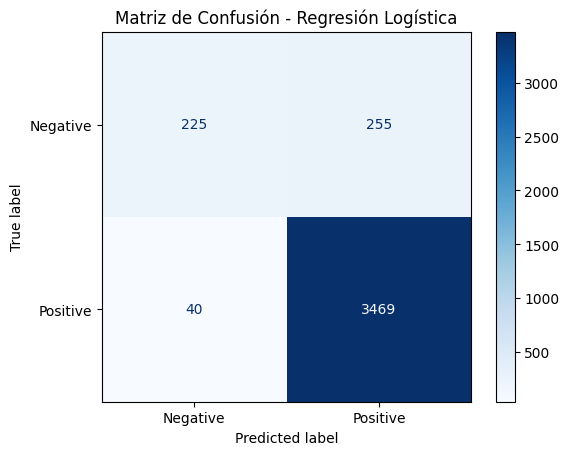


Análisis de la Matriz de Confusión:
Verdaderos Negativos (TN): 225 (Reseñas negativas correctamente clasificadas como negativas)
Falsos Positivos (FP):      255 (Reseñas negativas incorrectamente clasificadas como positivas) - Error Tipo I
Falsos Negativos (FN):     40 (Reseñas positivas incorrectamente clasificadas como negativas) - Error Tipo II
Verdaderos Positivos (TP):  3469 (Reseñas positivas correctamente clasificadas como positivas)


In [66]:
 #Modelo Base: Regresión Logística
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt # Para graficar la matriz de confusión

print("--- Entrenando y Evaluando un Modelo Base: Regresión Logística ---")

# Verificar que los datos de entrenamiento y prueba estén definidos
if 'X_train' not in globals() or 'X_test' not in globals() or \
   'y_train' not in globals() or 'y_test' not in globals():
    print("Error: Los conjuntos de entrenamiento o prueba (X_train, X_test, y_train, y_test) no están definidos.")
    print("Asegúrate de que la sección 2.1 (División de Datos) se haya ejecutado correctamente.")
    raise NameError("Datos de entrenamiento/prueba no definidos.")

# Inicializar el modelo de Regresión Logística
# Podemos ajustar hiperparámetros como 'C' (inversa de la fuerza de regularización)
# solver='liblinear' es una buena opción para datasets de este tamaño y problemas binarios.
# max_iter podría necesitar ser aumentado si el modelo no converge.

log_reg_model = LogisticRegression(solver='liblinear', random_state=42, C=1.0, max_iter=1000)

print("\nEntrenando el modelo de Regresión Logística...")
# Entrenar el modelo con los datos de entrenamiento (TF-IDF)
log_reg_model.fit(X_train, y_train)
print("Modelo entrenado.")

# Realizar predicciones en el conjunto de prueba
y_pred_log_reg = log_reg_model.predict(X_test)
print("Predicciones realizadas en el conjunto de prueba.")

# Evaluar el modelo
print("\n--- Evaluación del Modelo de Regresión Logística ---")

# 1. Accuracy
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f"Accuracy (Exactitud): {accuracy_log_reg:.4f} (o {accuracy_log_reg*100:.2f}%)")

# 2. Classification Report (Precision, Recall, F1-score)
print("\nInforme de Clasificación:")
# target_names se usa para dar etiquetas a las clases 0 y 1 en el informe.
# Asumimos 0: Negative, 1: Positive
class_report_log_reg = classification_report(y_test, y_pred_log_reg, target_names=['Negative (0)', 'Positive (1)'])
print(class_report_log_reg)

# 3. Matriz de Confusión
print("\nMatriz de Confusión:")
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
# print(cm_log_reg) # Imprimir la matriz numérica

# Visualizar la Matriz de Confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

print("\nAnálisis de la Matriz de Confusión:")
tn, fp, fn, tp = cm_log_reg.ravel() # True Negatives, False Positives, False Negatives, True Positives
print(f"Verdaderos Negativos (TN): {tn} (Reseñas negativas correctamente clasificadas como negativas)")
print(f"Falsos Positivos (FP):      {fp} (Reseñas negativas incorrectamente clasificadas como positivas) - Error Tipo I")
print(f"Falsos Negativos (FN):     {fn} (Reseñas positivas incorrectamente clasificadas como negativas) - Error Tipo II")
print(f"Verdaderos Positivos (TP):  {tp} (Reseñas positivas correctamente clasificadas como positivas)")

--- Entrenando y Evaluando un Modelo Base: Regresión Logística ---

Entrenando el modelo de Regresión Logística...
Modelo entrenado.
Predicciones realizadas en el conjunto de prueba.

--- Evaluación del Modelo de Regresión Logística ---
Accuracy (Exactitud): 0.8907 (o 89.07%)

Informe de Clasificación:
              precision    recall  f1-score   support

Negative (0)       0.53      0.87      0.66       480
Positive (1)       0.98      0.89      0.94      3509

    accuracy                           0.89      3989
   macro avg       0.75      0.88      0.80      3989
weighted avg       0.93      0.89      0.90      3989


Matriz de Confusión:


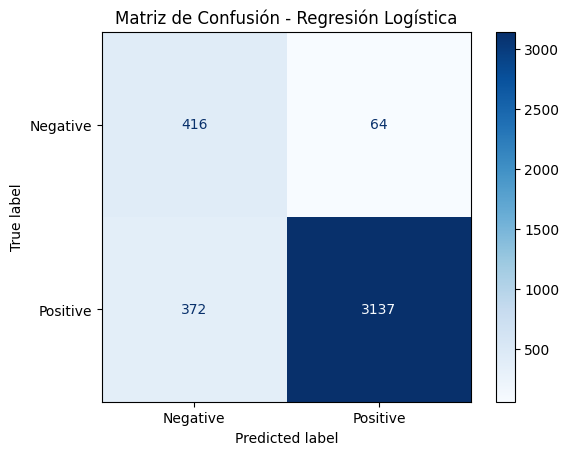


Análisis de la Matriz de Confusión:
Verdaderos Negativos (TN): 416 (Reseñas negativas correctamente clasificadas como negativas)
Falsos Positivos (FP):      64 (Reseñas negativas incorrectamente clasificadas como positivas) - Error Tipo I
Falsos Negativos (FN):     372 (Reseñas positivas incorrectamente clasificadas como negativas) - Error Tipo II
Verdaderos Positivos (TP):  3137 (Reseñas positivas correctamente clasificadas como positivas)


In [67]:
 #Modelo Base: Regresión Logística
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt # Para graficar la matriz de confusión

print("--- Entrenando y Evaluando un Modelo Base: Regresión Logística ---")

# Verificar que los datos de entrenamiento y prueba estén definidos
if 'X_train' not in globals() or 'X_test' not in globals() or \
   'y_train' not in globals() or 'y_test' not in globals():
    print("Error: Los conjuntos de entrenamiento o prueba (X_train, X_test, y_train, y_test) no están definidos.")
    print("Asegúrate de que la sección 2.1 (División de Datos) se haya ejecutado correctamente.")
    raise NameError("Datos de entrenamiento/prueba no definidos.")

# Inicializar el modelo de Regresión Logística
# Podemos ajustar hiperparámetros como 'C' (inversa de la fuerza de regularización)
# solver='liblinear' es una buena opción para datasets de este tamaño y problemas binarios.
# max_iter podría necesitar ser aumentado si el modelo no converge.

log_reg_model = LogisticRegression(solver='liblinear', random_state=42, C=1.0,class_weight='balanced',  max_iter=1000)

print("\nEntrenando el modelo de Regresión Logística...")
# Entrenar el modelo con los datos de entrenamiento (TF-IDF)
log_reg_model.fit(X_train, y_train)
print("Modelo entrenado.")

# Realizar predicciones en el conjunto de prueba
y_pred_log_reg = log_reg_model.predict(X_test)
print("Predicciones realizadas en el conjunto de prueba.")

# Evaluar el modelo
print("\n--- Evaluación del Modelo de Regresión Logística ---")

# 1. Accuracy
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f"Accuracy (Exactitud): {accuracy_log_reg:.4f} (o {accuracy_log_reg*100:.2f}%)")

# 2. Classification Report (Precision, Recall, F1-score)
print("\nInforme de Clasificación:")
# target_names se usa para dar etiquetas a las clases 0 y 1 en el informe.
# Asumimos 0: Negative, 1: Positive
class_report_log_reg = classification_report(y_test, y_pred_log_reg, target_names=['Negative (0)', 'Positive (1)'])
print(class_report_log_reg)

# 3. Matriz de Confusión
print("\nMatriz de Confusión:")
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
# print(cm_log_reg) # Imprimir la matriz numérica

# Visualizar la Matriz de Confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

print("\nAnálisis de la Matriz de Confusión:")
tn, fp, fn, tp = cm_log_reg.ravel() # True Negatives, False Positives, False Negatives, True Positives
print(f"Verdaderos Negativos (TN): {tn} (Reseñas negativas correctamente clasificadas como negativas)")
print(f"Falsos Positivos (FP):      {fp} (Reseñas negativas incorrectamente clasificadas como positivas) - Error Tipo I")
print(f"Falsos Negativos (FN):     {fn} (Reseñas positivas incorrectamente clasificadas como negativas) - Error Tipo II")
print(f"Verdaderos Positivos (TP):  {tp} (Reseñas positivas correctamente clasificadas como positivas)")

# Interpretación de los Resultados


Interpretación

**Modelo Base (sin penalización):**

Muy buen rendimiento general.
Alta precisión y recall para la clase positiva, pero muy bajo recall para la clase negativa (solo detecta el 47% de las negativas).
Muchos falsos positivos: clasifica erróneamente muchas reseñas negativas como positivas.

**Modelo con class_weight='balanced':**

Mejora notable en el recall de la clase negativa (sube de 0.47 a 0.87).
Reduce drásticamente los falsos positivos (de 255 a 64).
Disminuye el recall de la clase positiva (de 0.99 a 0.89), lo que genera más falsos negativos.

Accuracy general baja un poco, pero el modelo es más equilibrado entre clases.

# Conclusión

Si tu objetivo es detectar reseñas negativas con mayor precisión, el modelo con penalización (class_weight='balanced') es claramente mejor.

Si prefieres maximizar la precisión global y detectar reseñas positivas con alta seguridad, el modelo base es más adecuado.

En contextos sensibles (como atención al cliente o moderación), equilibrar el rendimiento entre clases suele ser preferible, incluso si eso implica sacrificar algo de exactitud general.

# #Modelo de Red Neuronal Artificial (ANN)

---Entrenando y Evaluando un Modelo de Red Neuronal Artificial (ANN) ---

Arquitectura del Modelo ANN:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "ANN_Sentimiento_Uber"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Capa_Entrada_Oculta1 (Dense)    │ (None, 128)            │       459,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Capa_Oculta2 (Dense)            │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout2 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Capa_Salida (Dense)             │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,329 (1.78 MB)

 Trainable params: 467,329 (1.78 MB)

 Non-trainable params: 0 (0.00 B)


Entrenando el modelo ANN...
Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8714 - loss: 0.3584 - val_accuracy: 0.9167 - val_loss: 0.1971
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9346 - loss: 0.1535 - val_accuracy: 0.9204 - val_loss: 0.1949
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9511 - loss: 0.1168 - val_accuracy: 0.9204 - val_loss: 0.1970
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9650 - loss: 0.0862 - val_accuracy: 0.9179 - val_loss: 0.2287
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9785 - loss: 0.0621 - val_accuracy: 0.9254 - val_loss: 0.2523
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9834 - loss: 0.0488 - val_accuracy: 0.9248 - val_loss: 0.3019
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9870 - loss: 0.0365 - val_accuracy: 0.9229 - val_loss: 0.3489
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.991

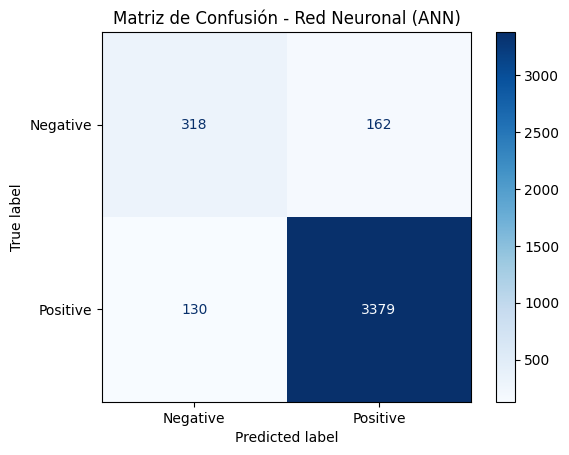


Análisis de la Matriz de Confusión (ANN):
Verdaderos Negativos (TN): 318
Falsos Positivos (FP):      162
Falsos Negativos (FN):     130
Verdaderos Positivos (TP):  3379

--- Historial de Entrenamiento del Modelo ANN ---


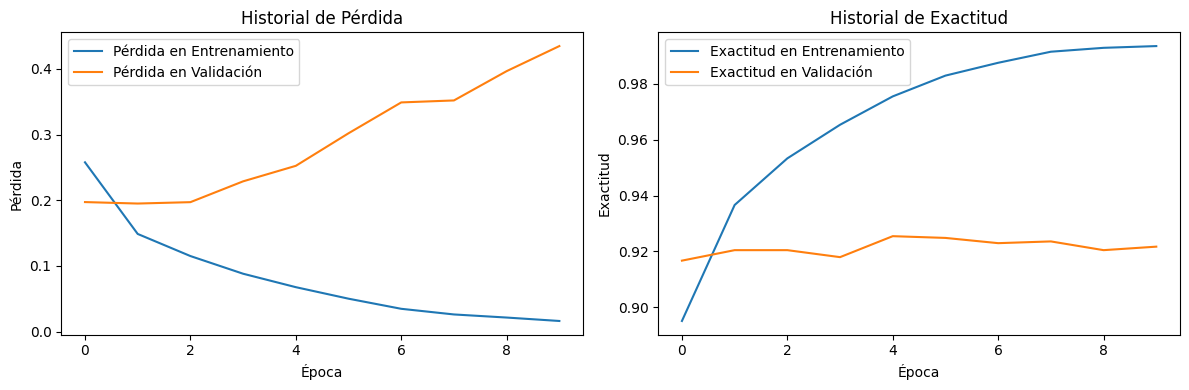

In [62]:
 #Modelo de Red Neuronal Artificial (ANN)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay # Ya importadas, pero por claridad
import matplotlib.pyplot as plt # Ya importado

print("---Entrenando y Evaluando un Modelo de Red Neuronal Artificial (ANN) ---")

# Verificar que los datos de entrenamiento y prueba estén definidos
if 'X_train' not in globals() or 'X_test' not in globals() or \
   'y_train' not in globals() or 'y_test' not in globals():
    print("Error: Los conjuntos de entrenamiento o prueba no están definidos.")
    raise NameError("Datos de entrenamiento/prueba no definidos para ANN.")

# Las redes neuronales densas en Keras pueden manejar matrices dispersas (como X_train de TF-IDF)
# directamente en muchos casos, especialmente si están en formato CSR.
# Si hubiera problemas, se podría convertir X_train y X_test a arrays densos con .toarray(),
# pero esto puede consumir mucha memoria si el vocabulario es grande.
# X_train_dense = X_train.toarray() # Descomentar solo si es necesario y se tiene suficiente RAM
# X_test_dense = X_test.toarray()   # Descomentar solo si es necesario y se tiene suficiente RAM

# Definir la arquitectura de la Red Neuronal Secuencial
ann_model = Sequential(name="ANN_Sentimiento_Uber")
ann_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu', name='Capa_Entrada_Oculta1'))
ann_model.add(Dropout(0.5, name='Dropout1')) # Dropout para regularización
ann_model.add(Dense(64, activation='relu', name='Capa_Oculta2'))
ann_model.add(Dropout(0.3, name='Dropout2')) # Dropout para regularización
ann_model.add(Dense(1, activation='sigmoid', name='Capa_Salida')) # Capa de salida para clasificación binaria

# Compilar el modelo
# Optimizador 'adam' es una buena elección general.
# 'binary_crossentropy' es la función de pérdida para clasificación binaria.
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Mostrar un resumen de la arquitectura del modelo
print("\nArquitectura del Modelo ANN:")
ann_model.summary()

print("\nEntrenando el modelo ANN...")
# Entrenar el modelo
# epochs: número de veces que el modelo verá el conjunto de datos completo.
# batch_size: número de muestras que se propagarán a través de la red antes de actualizar los pesos.
# validation_split: fracción delos datos de entrenamiento que se usará como datos de validación (para monitorear overfitting).
# callbacks: para early stopping, guardar el mejor modelo, etc. (opcional por ahora para simplificar)
# verbose=1 para mostrar el progreso del entrenamiento
history = ann_model.fit(X_train, y_train,
                        epochs=10, # Puedes experimentar con más épocas
                        batch_size=32, # Común, puedes experimentar
                        validation_split=0.1, # Usar 10% de los datos de entrenamiento para validación
                        verbose=1)

print("Modelo ANN entrenado.")

# Evaluar el modelo en el conjunto de prueba
print("\n--- Evaluación del Modelo ANN en el conjunto de prueba ---")
loss_ann, accuracy_ann = ann_model.evaluate(X_test, y_test, verbose=0)
print(f"Pérdida (Loss) en el conjunto de prueba: {loss_ann:.4f}")
print(f"Accuracy (Exactitud) en el conjunto de prueba: {accuracy_ann:.4f} (o {accuracy_ann*100:.2f}%)")

# Realizar predicciones para obtener el informe de clasificación y la matriz de confusión
# Las predicciones de la capa sigmoide son probabilidades. Necesitamos convertirlas a clases (0 o 1).
y_pred_proba_ann = ann_model.predict(X_test)
y_pred_ann = (y_pred_proba_ann > 0.5).astype(int) # Umbral de 0.5 para convertir probabilidades a clase binaria

print("\nInforme de Clasificación (ANN):")
class_report_ann = classification_report(y_test, y_pred_ann, target_names=['Negative (0)', 'Positive (1)'])
print(class_report_ann)

print("\nMatriz de Confusión (ANN):")
cm_ann = confusion_matrix(y_test, y_pred_ann)
disp_ann = ConfusionMatrixDisplay(confusion_matrix=cm_ann, display_labels=['Negative', 'Positive'])
disp_ann.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - Red Neuronal (ANN)')
plt.show()

print("\nAnálisis de la Matriz de Confusión (ANN):")
tn_ann, fp_ann, fn_ann, tp_ann = cm_ann.ravel()
print(f"Verdaderos Negativos (TN): {tn_ann}")
print(f"Falsos Positivos (FP):      {fp_ann}")
print(f"Falsos Negativos (FN):     {fn_ann}")
print(f"Verdaderos Positivos (TP):  {tp_ann}")

# Graficar historial de entrenamiento (pérdida y exactitud)
if history:
    print("\n--- Historial de Entrenamiento del Modelo ANN ---")
    # Graficar la pérdida
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida en Validación')
    plt.title('Historial de Pérdida')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    # Graficar la exactitud
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Exactitud en Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Exactitud en Validación')
    plt.title('Historial de Exactitud')
    plt.xlabel('Época')
    plt.ylabel('Exactitud')
    plt.legend()

    plt.tight_layout()
    plt.show()

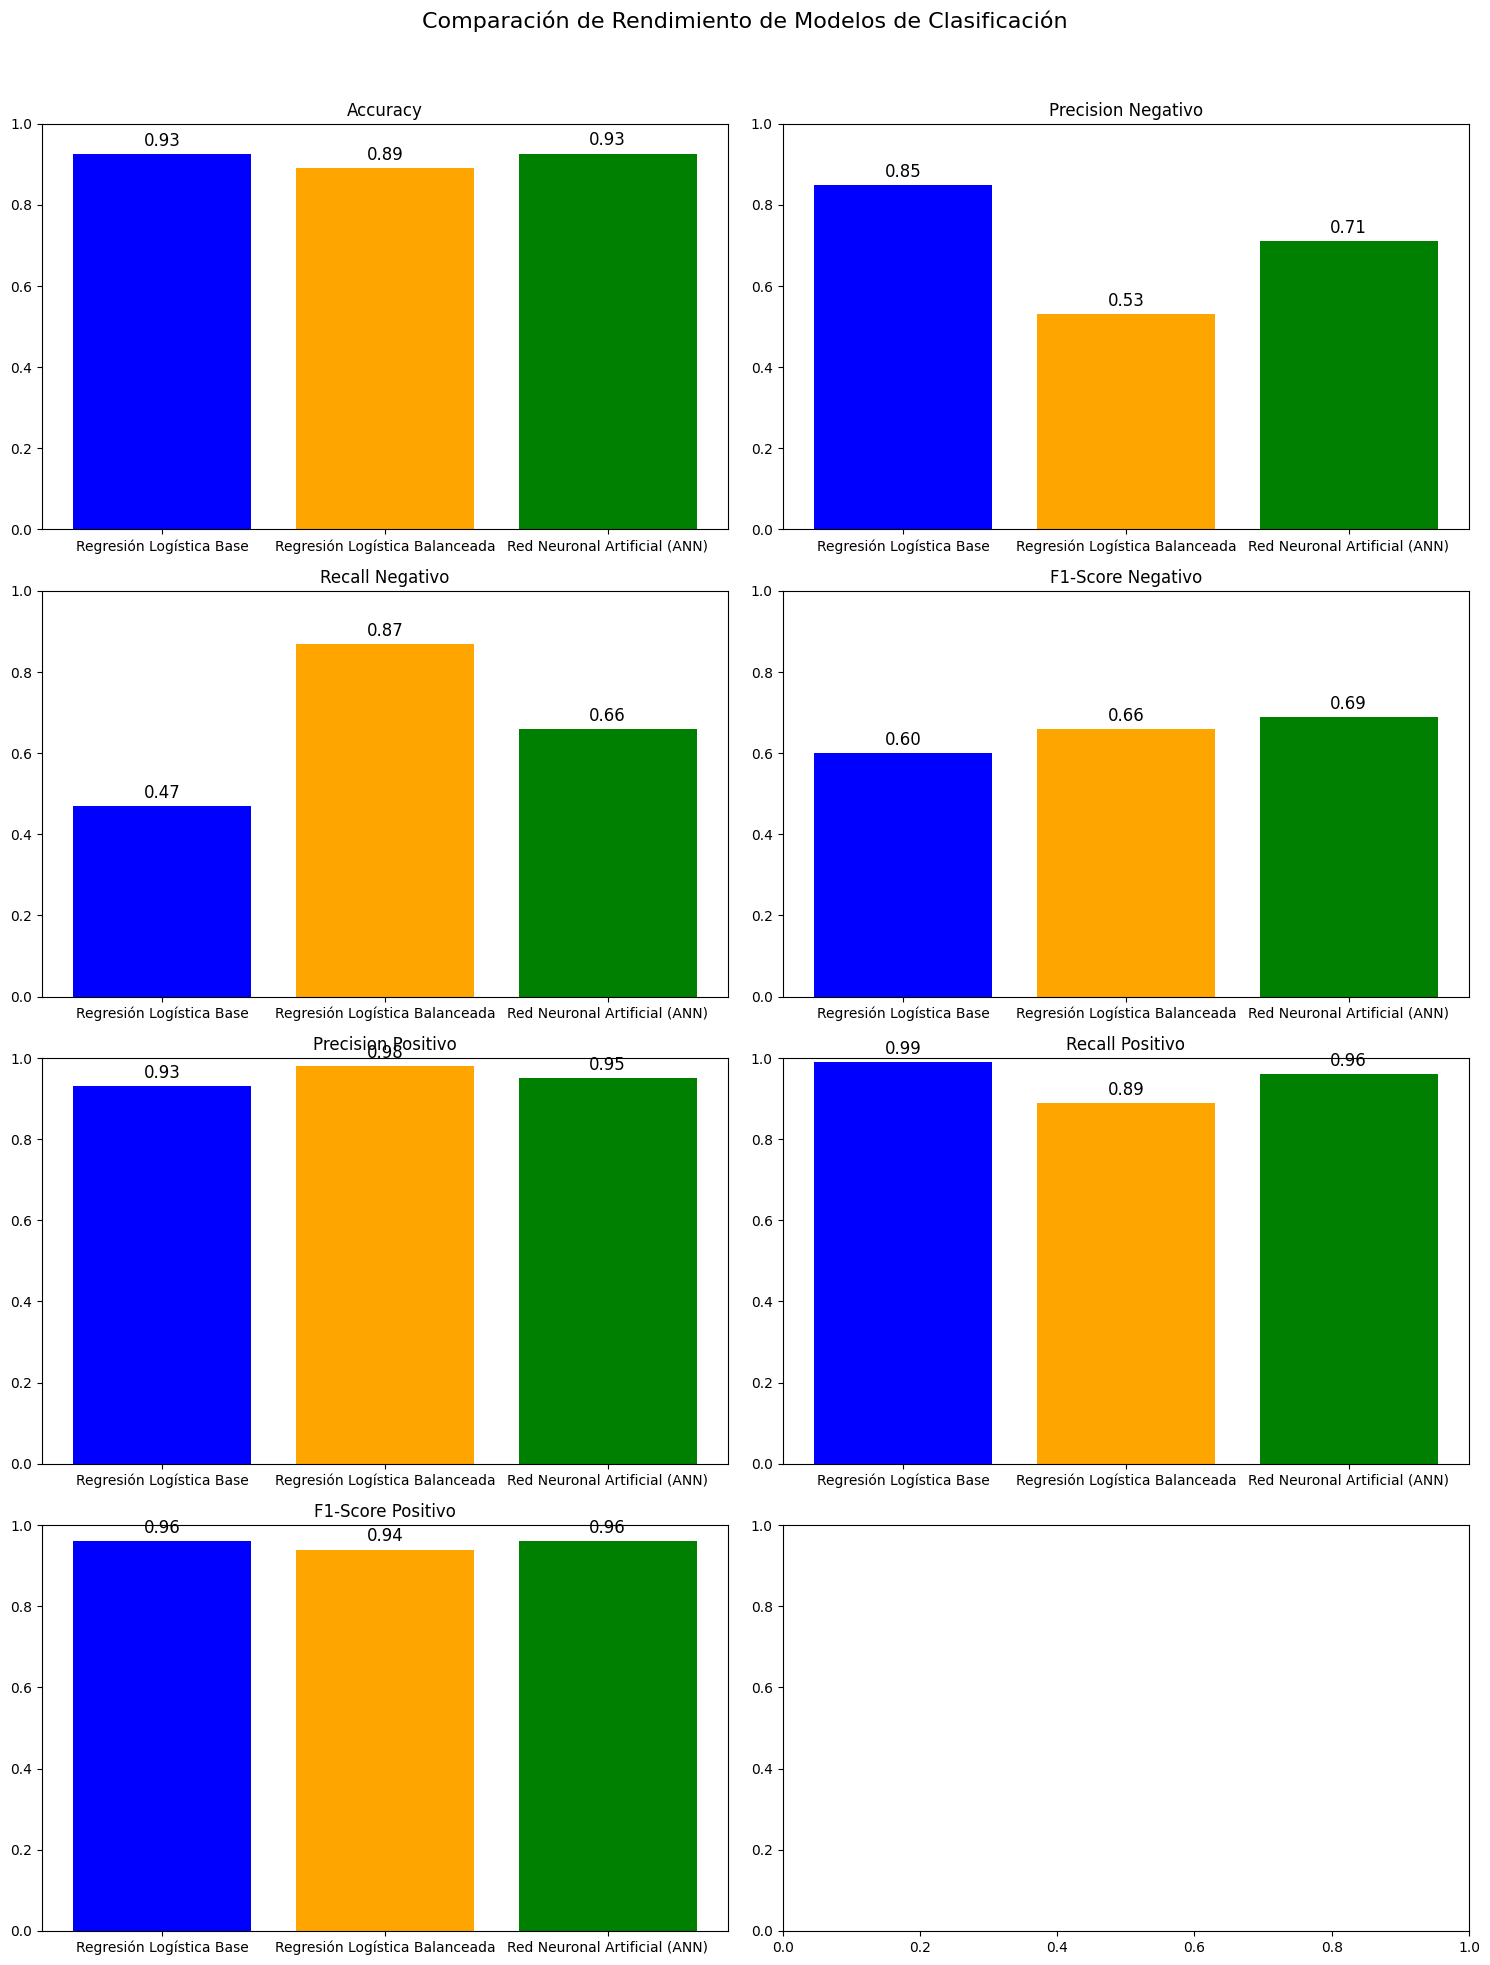

In [72]:

# Métricas de rendimiento de los modelos
metrics = {
 "Accuracy": [0.9260, 0.8907, 0.9268],
 "Precision Negativo": [0.85, 0.53, 0.71],
 "Recall Negativo": [0.47, 0.87, 0.66],
 "F1-Score Negativo": [0.60, 0.66, 0.69],
 "Precision Positivo": [0.93, 0.98, 0.95],
 "Recall Positivo": [0.99, 0.89, 0.96],
 "F1-Score Positivo": [0.96, 0.94, 0.96]
}

models = ["Regresión Logística Base", "Regresión Logística Balanceada", "Red Neuronal Artificial (ANN)"]

# Crear gráficos para cada métrica
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle('Comparación de Rendimiento de Modelos de Clasificación', fontsize=16)

for i, (metric, values) in enumerate(metrics.items()):
    ax = axes[i // 2, i % 2]
    ax.bar(models, values, color=['blue', 'orange', 'green'])
    ax.set_title(metric)
    ax.set_ylim(0, 1)
    for j, value in enumerate(values):
       ax.text(j, value + 0.02, f"{value:.2f}", ha='center', fontsize=12)

# Ajustar el diseño y mostrar los gráficos
plt.tight_layout(rect=[0, 0, 1, 0.96])



# ¿Qué muestra cada gráfico?
Accuracy:

La ANN y la Regresión Logística Base tienen una precisión general muy similar (~92.6%).

El modelo con class_weight='balanced' tiene menor accuracy, pero compensa en otras métricas.

Precision por clase:


La ANN logra un buen equilibrio entre clases.
La Regresión Logística Base favorece la clase positiva.
El modelo balanceado mejora la precisión para la clase positiva, pero baja para la negativa.


Recall por clase:

El modelo balanceado sobresale en recall para la clase negativa (0.87).
La ANN también mejora el recall negativo respecto al modelo base.
El modelo base tiene el mejor recall para la clase positiva (0.99).


F1-Score por clase:

La ANN logra el mejor equilibrio general.
El modelo base tiene el mejor F1 para positivos, pero bajo para negativos.
El modelo balanceado mejora el F1 para negativos, pero baja un poco para positivos.


--- Preparando datos para el modelo LSTM con Embedding ---
Tamaño de los conjuntos de datos: Entrenamiento=14956, Prueba=4986
Tamaño del vocabulario (vocab_size) detectado: 12409
Textos convertidos a secuencias numéricas.
Longitud máxima de la secuencia (max_length) detectada en entrenamiento: 63
Secuencias rellenadas/truncadas.
Shape de X_train_padded: (14956, 63)
Shape de X_test_padded: (4986, 63)

--- Definiendo y Compilando el Modelo LSTM ---

Arquitectura del Modelo LSTM:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "LSTM_Sentimiento"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Capa_Embedding (Embedding)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Capa_LSTM (LSTM)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Capa_Salida (Dense)             │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- Entrenando el modelo LSTM ---
Epoch 1/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 62s 140ms/step - accuracy: 0.8794 - loss: 0.3925 - val_accuracy: 0.8703 - val_loss: 0.3911
Epoch 2/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 57s 135ms/step - accuracy: 0.8799 - loss: 0.3726 - val_accuracy: 0.8703 - val_loss: 0.3886
Epoch 3/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 59s 139ms/step - accuracy: 0.8790 - loss: 0.3733 - val_accuracy: 0.8703 - val_loss: 0.3864
Epoch 4/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 84s 145ms/step - accuracy: 0.8772 - loss: 0.3652 - val_accuracy: 0.9104 - val_loss: 0.2400
Epoch 5/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 80s 141ms/step - accuracy: 0.9119 - loss: 0.2359 - val_accuracy: 0.9151 - val_loss: 0.2125
Epoch 6/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 85s 148ms/step - accuracy: 0.9500 - loss: 0.1387 - val_accuracy: 0.9158 - val_loss: 0.2200
Epoch 7/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 62s 147ms/step - accuracy: 0.9620 - loss: 0.1094 - val_accuracy: 0.9205 - val_loss: 0.2308
Epoch 8/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 80s 143m

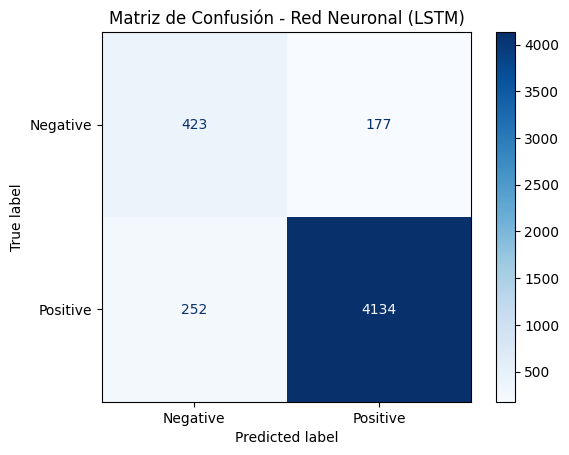


Análisis de la Matriz de Confusión (LSTM):
Verdaderos Negativos (TN): 423
Falsos Positivos (FP):      177
Falsos Negativos (FN):     252
Verdaderos Positivos (TP):  4134

--- Historial de Entrenamiento del Modelo LSTM ---


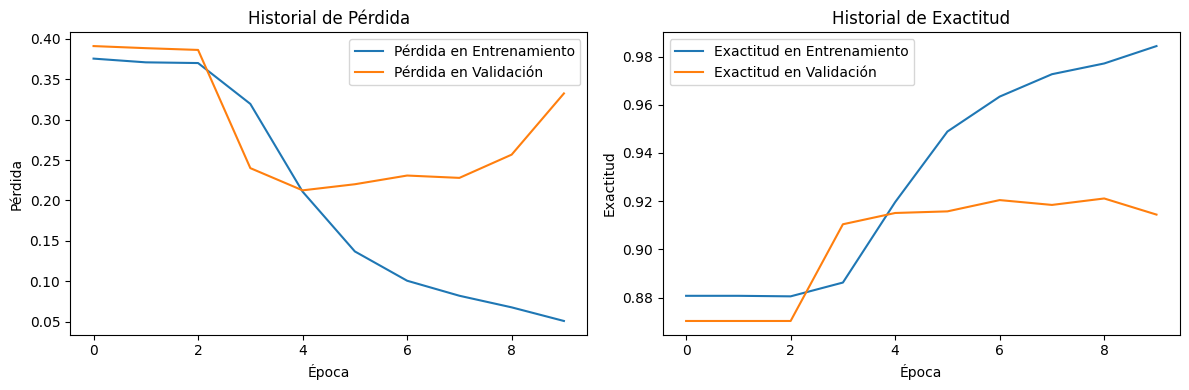

In [74]:


# Este es un modelo diferente que usa Embedding y LSTM

print("\n--- Preparando datos para el modelo LSTM con Embedding ---")

# Asumimos que df_processed['Tokens_Lematizados'] contiene las listas de tokens lematizados
# Necesitamos convertir estas listas de tokens en secuencias numéricas para el Embedding layer.

# Verificar que df_processed y 'Tokens_Lematizados' existan
if 'df_processed' not in globals() or 'Tokens_Lematizados' not in df_processed.columns:
    print("Error: df_processed o la columna 'Tokens_Lematizados' no están definidos.")
    raise NameError("df_processed o Tokens_Lematizados no definidos para preparar datos para Embedding.")

# 1. Convertir las listas de tokens de entrenamiento y prueba a cadenas de texto para el Tokenizer
# NOTA: Asumimos que ya has dividido tus datos en conjuntos de entrenamiento y prueba
# (ej. X_train_text, X_test_text, y_train, y_test) antes de llegar aquí.
# Si no has hecho la división, DEBES hacerla antes de este paso para evitar data leakage.
# Por simplicidad, vamos a crear una división aquí solo para demostrar la preparación de datos.
# En un notebook real, esta división se haría ANTES de vectorizar o tokenizar.

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Asegúrate de que 'Sentiment_Num' es tu etiqueta numérica (0 para Negative, 1 para Positive)
if 'Sentiment_Num' not in df_processed.columns:
    print("Error: Columna 'Sentiment_Num' no encontrada en df_processed.")
    raise ValueError("Columna 'Sentiment_Num' no disponible para la división de datos.")

# Asegúrate de que 'Tokens_Lematizados' es la característica de texto a usar
if 'Tokens_Lematizados' not in df_processed.columns:
     print("Error: Columna 'Tokens_Lematizados' no encontrada en df_processed.")
     raise ValueError("Columna 'Tokens_Lematizados' no disponible para la división de datos.")


# Convertir listas de tokens a cadenas de texto unidas por espacios
# Esto es lo que espera el Keras Tokenizer para el fiteo
df_processed['Tokens_Lematizados_Str'] = df_processed['Tokens_Lematizados'].apply(lambda x: " ".join(x))

# Dividir los datos ANTES de la tokenización para Keras
# Usar random_state para reproducibilidad
X = df_processed['Tokens_Lematizados_Str']
y = df_processed['Sentiment_Num']

# Usar el mismo split que se usó para el modelo anterior si es posible, o definir uno nuevo.
# Aquí usamos uno nuevo para asegurar que X_train_text y X_test_text estén disponibles.
X_train_text, X_test_text, y_train_lstm, y_test_lstm = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Tamaño de los conjuntos de datos: Entrenamiento={len(X_train_text)}, Prueba={len(X_test_text)}")

# 2. Configurar y fitear el Tokenizer
# num_words: el número máximo de palabras a mantener, basado en la frecuencia.
# oov_token: un token para representar palabras fuera del vocabulario.
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>") # Puedes ajustar num_words
tokenizer.fit_on_texts(X_train_text)

# Definir vocab_size
vocab_size = len(tokenizer.word_index) + 1 # +1 para el token de relleno (padding) o OOV si no se usó OOV_token=None
print(f"Tamaño del vocabulario (vocab_size) detectado: {vocab_size}")

# 3. Convertir texto a secuencias de enteros
X_train_sequences = tokenizer.texts_to_sequences(X_train_text)
X_test_sequences = tokenizer.texts_to_sequences(X_test_text)
print("Textos convertidos a secuencias numéricas.")

# 4. Determinar la longitud máxima de la secuencia y rellenar/truncar
# Puedes usar la longitud de la secuencia más larga o elegir un valor fijo.
# Usar la longitud máxima en el conjunto de entrenamiento es una opción común.
max_length = max(len(x) for x in X_train_sequences) # O elige un valor fijo como 100 o 200
print(f"Longitud máxima de la secuencia (max_length) detectada en entrenamiento: {max_length}")

# Rellenar/truncar secuencias
# padding='post' añade ceros al final; truncating='post' corta al final.
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

print("Secuencias rellenadas/truncadas.")
print(f"Shape de X_train_padded: {X_train_padded.shape}")
print(f"Shape de X_test_padded: {X_test_padded.shape}")

print("\n--- Definiendo y Compilando el Modelo LSTM ---")

# Ahora que vocab_size y max_length están definidos, podemos construir el modelo.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Definir la arquitectura del modelo LSTM
model = Sequential(name="LSTM_Sentimiento")
# Capa de Embedding: input_dim es el tamaño del vocabulario, output_dim es la dimensión del espacio vectorial
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length, name='Capa_Embedding'))
model.add(LSTM(128, return_sequences=False, name='Capa_LSTM')) # LSTM layer
model.add(Dropout(0.5, name='Dropout1')) # Dropout para regularización
model.add(Dense(1, activation='sigmoid', name='Capa_Salida')) # Capa de salida para clasificación binaria

# Compilar el modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Mostrar resumen del modelo
print("\nArquitectura del Modelo LSTM:")
model.summary()

print("\n--- Entrenando el modelo LSTM ---")
# Entrenar el modelo usando los datos secuenciados y rellenados
# Usamos y_train_lstm y y_test_lstm que corresponden a la división de texto.
history_lstm = model.fit(X_train_padded, y_train_lstm,
                         epochs=10, # Número de épocas (ajustar según validación)
                         batch_size=32, # Tamaño del batch
                         validation_split=0.1, # 10% de entrenamiento para validación
                         verbose=1)

print("Modelo LSTM entrenado.")


print("\n--- Evaluación del Modelo LSTM en el conjunto de prueba ---")
# Evaluar el modelo
loss_lstm, accuracy_lstm = model.evaluate(X_test_padded, y_test_lstm, verbose=0)
print(f"Pérdida (Loss) en el conjunto de prueba: {loss_lstm:.4f}")
print(f"Accuracy (Exactitud) en el conjunto de prueba: {accuracy_lstm:.4f} (o {accuracy_lstm*100:.2f}%)")

# Realizar predicciones
y_pred_proba_lstm = model.predict(X_test_padded)
y_pred_lstm = (y_pred_proba_lstm > 0.5).astype(int) # Umbral de 0.5

print("\nInforme de Clasificación (LSTM):")
class_report_lstm = classification_report(y_test_lstm, y_pred_lstm, target_names=['Negative (0)', 'Positive (1)'])
print(class_report_lstm)

print("\nMatriz de Confusión (LSTM):")
cm_lstm = confusion_matrix(y_test_lstm, y_pred_lstm)
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=['Negative', 'Positive'])
disp_lstm.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - Red Neuronal (LSTM)')
plt.show()

print("\nAnálisis de la Matriz de Confusión (LSTM):")
tn_lstm, fp_lstm, fn_lstm, tp_lstm = cm_lstm.ravel()
print(f"Verdaderos Negativos (TN): {tn_lstm}")
print(f"Falsos Positivos (FP):      {fp_lstm}")
print(f"Falsos Negativos (FN):     {fn_lstm}")
print(f"Verdaderos Positivos (TP):  {tp_lstm}")

# Graficar historial de entrenamiento (pérdida y exactitud)
if history_lstm:
    print("\n--- Historial de Entrenamiento del Modelo LSTM ---")
    # Graficar la pérdida
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_lstm.history['loss'], label='Pérdida en Entrenamiento')
    plt.plot(history_lstm.history['val_loss'], label='Pérdida en Validación')
    plt.title('Historial de Pérdida')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    # Graficar la exactitud
    plt.subplot(1, 2, 2)
    plt.plot(history_lstm.history['accuracy'], label='Exactitud en Entrenamiento')
    plt.plot(history_lstm.history['val_accuracy'], label='Exactitud en Validación')
    plt.title('Historial de Exactitud')
    plt.xlabel('Época')
    plt.ylabel('Exactitud')
    plt.legend()

    plt.tight_layout()
    plt.show()

LSTM logra un buen equilibrio entre precisión y recall para ambas clases.
Mejora el recall negativo respecto a la ANN y la Regresión Logística Base.
Tiene un accuracy competitivo (91.40%), aunque ligeramente inferior al de la ANN y el modelo base.
Su F1-score positivo (0.95) es muy alto, lo que indica que sigue siendo excelente para detectar reseñas positivas

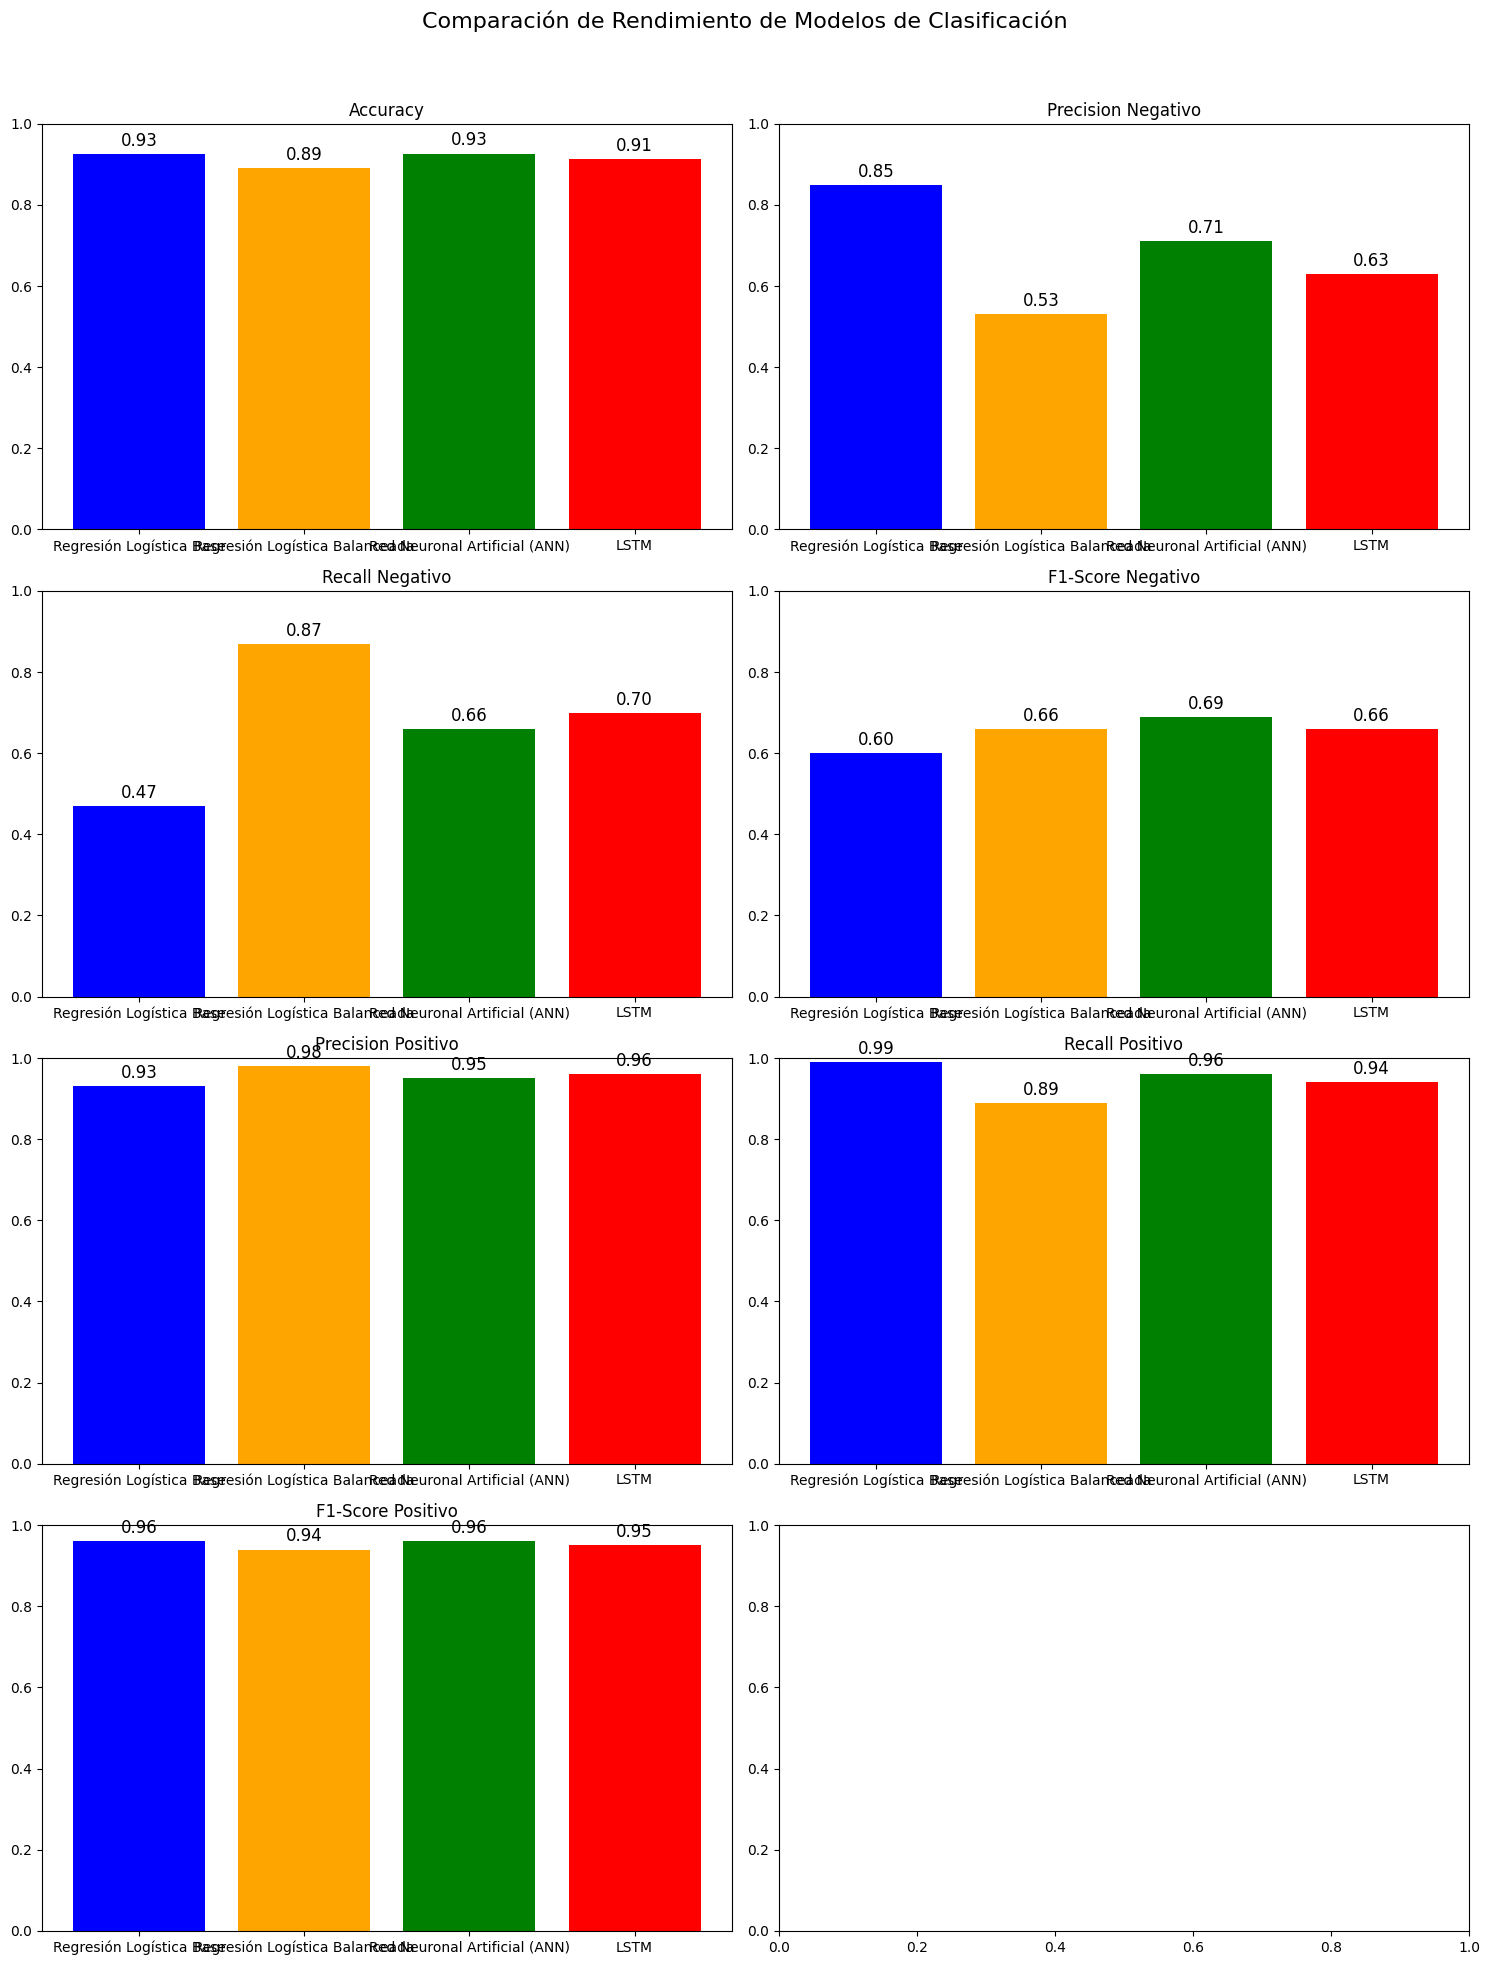

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Métricas de rendimiento de los modelos
metrics = {
 "Accuracy": [0.9260, 0.8907, 0.9268, 0.9140],
 "Precision Negativo": [0.85, 0.53, 0.71, 0.63],
 "Recall Negativo": [0.47, 0.87, 0.66, 0.70],
 "F1-Score Negativo": [0.60, 0.66, 0.69, 0.66],
 "Precision Positivo": [0.93, 0.98, 0.95, 0.96],
 "Recall Positivo": [0.99, 0.89, 0.96, 0.94],
"F1-Score Positivo": [0.96, 0.94, 0.96, 0.95]
}

models = ["Regresión Logística Base", "Regresión Logística Balanceada", "Red Neuronal Artificial (ANN)", "LSTM"]

# Crear gráficos para cada métrica
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle('Comparación de Rendimiento de Modelos de Clasificación', fontsize=16)

for i, (metric, values) in enumerate(metrics.items()):
 ax = axes[i // 2, i % 2]
 ax.bar(models, values, color=['blue', 'orange', 'green', 'red'])
 ax.set_title(metric)
 ax.set_ylim(0, 1)
 for j, value in enumerate(values):
    ax.text(j, value + 0.02, f"{value:.2f}", ha='center', fontsize=12)

# Ajustar el diseño y mostrar los gráficos
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



**Contexto del Problema**
Las reseñas de ropa femenina suelen contener lenguaje subjetivo, expresiones emocionales y variaciones estilísticas.
Es importante detectar tanto elogios (positivos) como críticas (negativas) con precisión.
El modelo ideal debe tener alto recall para ambas clases, especialmente para la clase negativa, ya que las críticas son menos frecuentes pero muy valiosas para mejorar productos y atención al cliente.

**Modelo Recomendado: Red Neuronal Artificial (ANN)**
Mejor balance general entre precisión y recall para ambas clases.
F1-score alto para negativos (0.69), lo que indica que detecta críticas con buena precisión y consistencia.
F1-score positivo (0.96) igual al mejor modelo.
Accuracy más alto (92.68%), lo que indica buen rendimiento global.

**Alternativa sólida: LSTM**
Captura mejor el contexto secuencial del lenguaje.
Mejor recall negativo (0.70) que la ANN, útil si te interesa detectar más críticas aunque con un poco más de falsos positivos.
Requiere más recursos computacionales y tiempo de entrenamiento.

**¿Cuándo usar Regresión Logística Balanceada?**
Si necesitas un modelo rápido y simple que priorice la detección de críticas negativas (recall negativo = 0.87), aunque sacrifiques algo de precisión general.


# Conclusión
Para un negocio de ropa femenina que busca entender tanto elogios como críticas de sus clientas, la ANN ofrece el mejor equilibrio entre rendimiento y eficiencia. Si tienes más datos o recursos, LSTM puede ser una excelente evolución.